In [2]:
import pandas as pd
import numpy as np
import os

# 🪡 Step 1 - Integrating EIA-860 Thermoelectric Cooling System Datasets
### Objective:
Combine multiple tables from the EIA-860 Annual Electric Generator Report to create a unified dataset on thermoelectric plant cooling systems, generator configurations, and associated attributes for analysis.

### Background:
Form EIA-860 collects detailed, generator-level data on existing and planned electric generators at U.S. power plants with 1 MW or greater capacity, including information on cooling systems, fuel types, and environmental equipment.

(Perplexity AI)

In [4]:
# List of file paths
file_paths = [
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/Cooling_Boiler_Generator_Data_Detail_2023.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/Cooling_Boiler_Generator_Data_Detail_2022.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/Cooling_Boiler_Generator_Data_Detail_2021.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/cooling_detail_2020.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/cooling_detail_2019.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/cooling_detail_2018.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/cooling_detail_2017.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/cooling_detail_2016.xlsx',
    '/Users/amyzhang/Desktop/A6_Dashboard/Datasets/Environmental/cooling_detail_2015.xlsx'
]

# Function to read Excel file
def read_excel(file_path):
    return pd.read_excel(file_path, header=2)  # header starts at row 3

# Read and merge all files
dfs = [read_excel(file) for file in file_paths]
cooling_boiler_df = pd.concat(dfs, ignore_index=True)

# Print info about the merged dataframe
print(f"Shape of merged dataframe: {cooling_boiler_df.shape}")

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be

Shape of merged dataframe: (751524, 70)


# 🧽 Step 2 – Initial Missingness Assessment + Pre-Clean

### Goal: 
- Identify obvious outliers or non-contributory records based on missing plant info, metric values, or system operability.
- Describe initial null patterns (e.g., missing state, plant_name, generator_id, etc.).
- Remove rows that clearly don’t contribute (e.g., entirely unoperable cooling systems with no metric values).
- Preserve rows that appear incomplete but still contain valuable metric data.

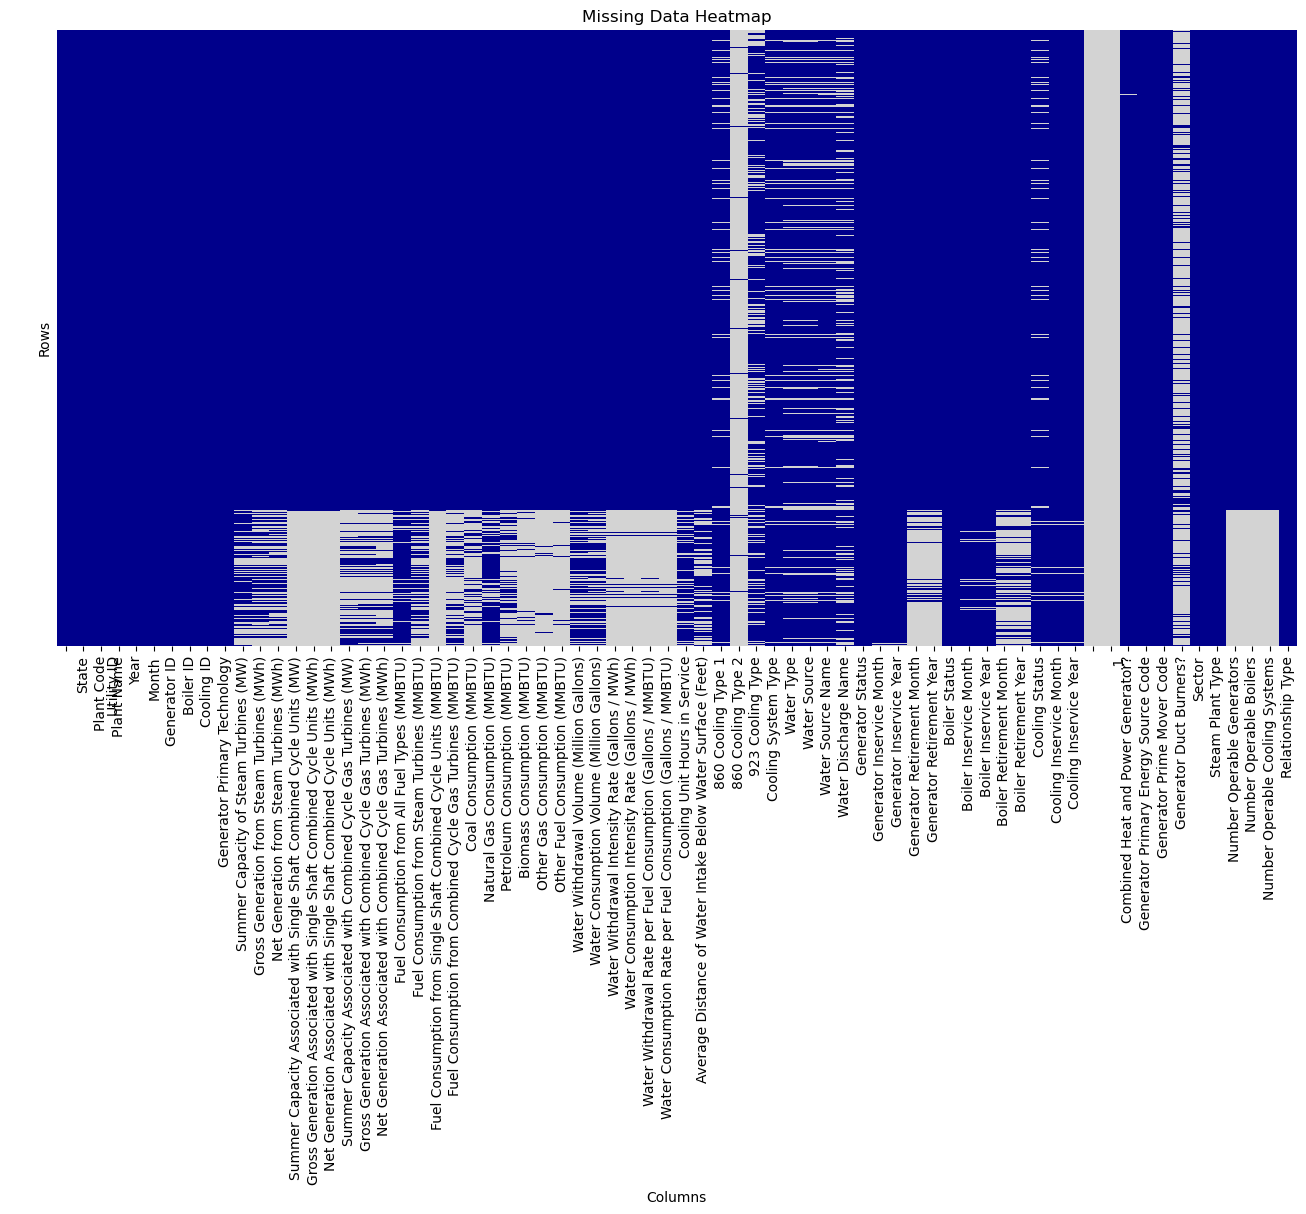

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np
from matplotlib.colors import ListedColormap

# Create a boolean DataFrame: True for missing, False for present
missing_mask = cooling_boiler_df.isnull()

# Define custom colors:
# Light gray for missing (True), soft blue for present (False)
colors = ["#00008B", "#D3D3D3"]  # dark blue, light gray

# Create a ListedColormap from these two colors
cmap = ListedColormap(colors)

heatmap_missingness = plt.figure(figsize=(16, 8))
sns.heatmap(
    missing_mask,
    cmap=cmap,
    cbar=False,
    yticklabels=False  # Hide row labels for clarity, optional
)
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


In [12]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/heatmap_missingness_ORIGINAL.png'
heatmap_missingness.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/heatmap_missingness_ORIGINAL.png


In [7]:
# Count of missing values per column
missing_count = cooling_boiler_df.isnull().sum()

# Percentage of missing values per column
missing_percentage = (missing_count / len(cooling_boiler_df)) * 100

# Combine into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
})

# Display the summary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_summary.to_string())

                                                                          Missing Count  Missing Percentage
\n \n \n \n \n \nUtility ID                                                           0            0.000000
State                                                                                24            0.003194
Plant Code                                                                            0            0.000000
Plant Name                                                                           24            0.003194
Year                                                                                  0            0.000000
Month                                                                                 0            0.000000
Generator ID                                                                        360            0.047903
Boiler ID                                                                           144            0.019161
Cooling ID                  

## 🧹 Preliminary Cleaning: columns dropped and re-named for SQL

In [9]:
import re

# Step 1: Remove unwanted columns
cols_to_drop = ['\n', '\n.1']
cooling_boiler_df = cooling_boiler_df.drop(columns=[col for col in cols_to_drop if col in cooling_boiler_df.columns])

# Step 2: Standardize column names
def clean_col(col):
    col = col.strip()  # Remove leading/trailing whitespace
    col = re.sub(r'\?', '', col)  # Remove question marks
    col = col.lower()  # Lowercase
    col = col.replace(' ', '_')  # Spaces to underscores
    col = re.sub(r'[^a-z0-9_]', '', col)  # Remove other special chars
    return col

cooling_boiler_df.columns = [clean_col(col) for col in cooling_boiler_df.columns]

# Step 3: Rename specific columns for clarity
rename_dict = {
    '860_cooling_type_1': 'cooling_type_1_860',
    '860_cooling_type_2': 'cooling_type_2_860',
    '923_cooling_type': 'cooling_type_923',
    'utility_id': 'utility_id',  # Ensure it's all lowercase and clean
}
cooling_boiler_df = cooling_boiler_df.rename(columns=rename_dict)


In [10]:
print("\nColumns in merged dataframe:")
print(cooling_boiler_df.columns.tolist())


Columns in merged dataframe:
['utility_id', 'state', 'plant_code', 'plant_name', 'year', 'month', 'generator_id', 'boiler_id', 'cooling_id', 'generator_primary_technology', 'summer_capacity_of_steam_turbines_mw', 'gross_generation_from_steam_turbines_mwh', 'net_generation_from_steam_turbines_mwh', 'summer_capacity_associated_with_single_shaft_combined_cycle_units_mw', 'gross_generation_associated_with_single_shaft_combined_cycle_units_mwh', 'net_generation_associated_with_single_shaft_combined_cycle_units_mwh', 'summer_capacity_associated_with_combined_cycle_gas_turbines_mw', 'gross_generation_associated_with_combined_cycle_gas_turbines_mwh', 'net_generation_associated_with_combined_cycle_gas_turbines_mwh', 'fuel_consumption_from_all_fuel_types_mmbtu', 'fuel_consumption_from_steam_turbines_mmbtu', 'fuel_consumption_from_single_shaft_combined_cycle_units_mmbtu', 'fuel_consumption_from_combined_cycle_gas_turbines_mmbtu', 'coal_consumption_mmbtu', 'natural_gas_consumption_mmbtu', 'petrol

## 📊 Heatmap: Missing Data

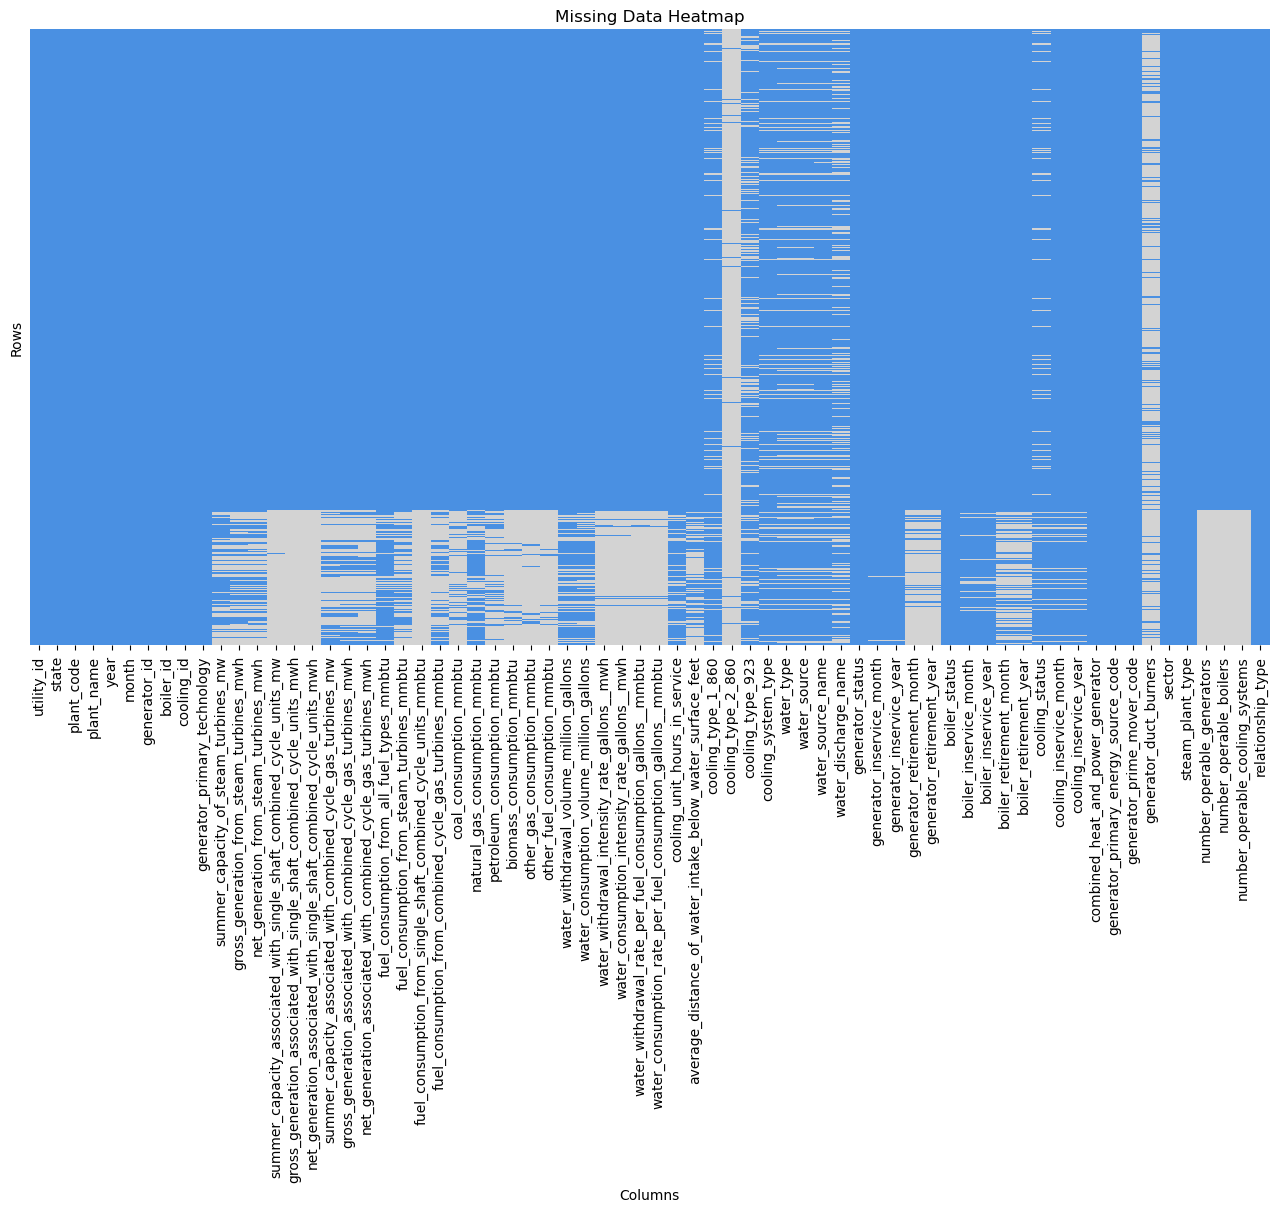

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np
from matplotlib.colors import ListedColormap

# Create a boolean DataFrame: True for missing, False for present
missing_mask = cooling_boiler_df.isnull()

# Define custom colors:
# Light gray for missing (True), soft blue for present (False)
colors = ["#4A90E2","#D3D3D3"]  # medium soft blue, light gray

# Create a ListedColormap from these two colors
cmap = ListedColormap(colors)

heatmap_missingness = plt.figure(figsize=(16, 8))
sns.heatmap(
    missing_mask,
    cmap=cmap,
    cbar=False,
    yticklabels=False  # Hide row labels for clarity, optional
)
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


In [13]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/heatmap_missingness.png'
heatmap_missingness.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/heatmap_missingness.png


## 🧹 Cleaning: Missing States

In [15]:
cooling_boiler_df[cooling_boiler_df['state'].isna()]


,utility_id,state,plant_code,plant_name,year,month,generator_id,boiler_id,cooling_id,generator_primary_technology,...,combined_heat_and_power_generator,generator_primary_energy_source_code,generator_prime_mover_code,generator_duct_burners,sector,steam_plant_type,number_operable_generators,number_operable_boilers,number_operable_cooling_systems,relationship_type
749376,58371,NaN,57273,NaN,2015,1,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749377,58371,NaN,57273,NaN,2015,2,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749378,58371,NaN,57273,NaN,2015,3,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749379,58371,NaN,57273,NaN,2015,4,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749380,58371,NaN,57273,NaN,2015,5,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749381,58371,NaN,57273,NaN,2015,6,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749382,58371,NaN,57273,NaN,2015,7,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749383,58371,NaN,57273,NaN,2015,8,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749384,58371,NaN,57273,NaN,2015,9,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable
749385,58371,NaN,57273,NaN,2015,10,NaN,A,1,NaN,...,NaN,NaN,NaN,NaN,IPP Non-CHP,NaN,NaN,NaN,NaN,Unoperable


#### a) Attempt to infer by plant_code

In [17]:
# Find all rows with plant_code 57273
plant_rows = cooling_boiler_df[cooling_boiler_df['plant_code'] == 57273]
print(plant_rows)


        utility_id state  plant_code plant_name  year  month generator_id  \
749376       58371   NaN       57273        NaN  2015      1          NaN   
749377       58371   NaN       57273        NaN  2015      2          NaN   
749378       58371   NaN       57273        NaN  2015      3          NaN   
749379       58371   NaN       57273        NaN  2015      4          NaN   
749380       58371   NaN       57273        NaN  2015      5          NaN   
749381       58371   NaN       57273        NaN  2015      6          NaN   
749382       58371   NaN       57273        NaN  2015      7          NaN   
749383       58371   NaN       57273        NaN  2015      8          NaN   
749384       58371   NaN       57273        NaN  2015      9          NaN   
749385       58371   NaN       57273        NaN  2015     10          NaN   
749386       58371   NaN       57273        NaN  2015     11          NaN   
749387       58371   NaN       57273        NaN  2015     12          NaN   

In [18]:
utility_rows = cooling_boiler_df[cooling_boiler_df['utility_id'] == 58371]
print(utility_rows)


        utility_id state  plant_code plant_name  year  month generator_id  \
749376       58371   NaN       57273        NaN  2015      1          NaN   
749377       58371   NaN       57273        NaN  2015      2          NaN   
749378       58371   NaN       57273        NaN  2015      3          NaN   
749379       58371   NaN       57273        NaN  2015      4          NaN   
749380       58371   NaN       57273        NaN  2015      5          NaN   
749381       58371   NaN       57273        NaN  2015      6          NaN   
749382       58371   NaN       57273        NaN  2015      7          NaN   
749383       58371   NaN       57273        NaN  2015      8          NaN   
749384       58371   NaN       57273        NaN  2015      9          NaN   
749385       58371   NaN       57273        NaN  2015     10          NaN   
749386       58371   NaN       57273        NaN  2015     11          NaN   
749387       58371   NaN       57273        NaN  2015     12          NaN   

### 👀 Conclusion: Remove Missing States
All 24 rows missing 'state' and 'plant_name' belong to the same plant_code and to the same utility_id. Each cooling system (see: 'relationship_type') listed for this plant (and utility_id) is marked as unoperable, meaning these entries won’t contribute to water metrics modeling or help illuminate patterns of missingness, as we would not expect water data for systems that aren’t operational. For these reasons, these rows are removed from the dataset. 

In [20]:
cooling_boiler_df = cooling_boiler_df[cooling_boiler_df['plant_code'] != 57273]


In [21]:
cooling_boiler_df.shape

(751500, 68)

## 🧹 Assess: Missing generator_id, boiler_id, cooling_id

In [23]:
# Do ROWS with missing id's have metric data? 

missing_id_rows = cooling_boiler_df[
    cooling_boiler_df['generator_id'].isna() |
    cooling_boiler_df['boiler_id'].isna() |
    cooling_boiler_df['cooling_id'].isna()
]

metric_columns = [
    'summer_capacity_of_steam_turbines_mw',
    'gross_generation_from_steam_turbines_mwh',
    'net_generation_from_steam_turbines_mwh',
    'summer_capacity_associated_with_single_shaft_combined_cycle_units_mw',
    'gross_generation_associated_with_single_shaft_combined_cycle_units_mwh',
    'net_generation_associated_with_single_shaft_combined_cycle_units_mwh',
    'summer_capacity_associated_with_combined_cycle_gas_turbines_mw',
    'gross_generation_associated_with_combined_cycle_gas_turbines_mwh',
    'net_generation_associated_with_combined_cycle_gas_turbines_mwh',
    'fuel_consumption_from_all_fuel_types_mmbtu',
    'fuel_consumption_from_steam_turbines_mmbtu',
    'fuel_consumption_from_single_shaft_combined_cycle_units_mmbtu',
    'fuel_consumption_from_combined_cycle_gas_turbines_mmbtu',
    'coal_consumption_mmbtu',
    'natural_gas_consumption_mmbtu',
    'petroleum_consumption_mmbtu',
    'biomass_consumption_mmbtu',
    'other_gas_consumption_mmbtu',
    'other_fuel_consumption_mmbtu',
    'water_withdrawal_volume_million_gallons',
    'water_consumption_volume_million_gallons',
    'water_withdrawal_intensity_rate_gallons__mwh',
    'water_consumption_intensity_rate_gallons__mwh',
    'water_withdrawal_rate_per_fuel_consumption_gallons__mmbtu',
    'water_consumption_rate_per_fuel_consumption_gallons__mmbtu',
    'cooling_unit_hours_in_service',
    'average_distance_of_water_intake_below_water_surface_feet'
]

# Create a boolean column: True if at least one metric column is non-missing
missing_id_rows = missing_id_rows.copy()
missing_id_rows['has_any_metric'] = missing_id_rows[metric_columns].notnull().any(axis=1)


# Show the relevant columns and the new boolean
print(missing_id_rows[['plant_code', 'state', 'generator_id', 'boiler_id', 'cooling_id', 'has_any_metric']])



        plant_code state generator_id boiler_id cooling_id  has_any_metric
34860         7242    FL          NaN        1B       RC01            True
34861         7242    FL          NaN        1B       RC01            True
34862         7242    FL          NaN        1B       RC01            True
34863         7242    FL          NaN        1B       RC01            True
34864         7242    FL          NaN        1B       RC01            True
...            ...   ...          ...       ...        ...             ...
751219       59859    TX          NaN       NaN        ACC           False
751220       59859    TX          NaN       NaN        ACC           False
751221       59859    TX          NaN       NaN        ACC           False
751222       59859    TX          NaN       NaN        ACC           False
751223       59859    TX          NaN       NaN        ACC           False

[360 rows x 6 columns]


In [24]:
missing_id_rows['has_any_metric'].value_counts()

has_any_metric
True     300
False     60
Name: count, dtype: int64

In [25]:
# Filter for rows where has_any_metric is False
no_metric_rows = missing_id_rows[missing_id_rows['has_any_metric'] == False]

# See all 60 rows:
print(no_metric_rows)


        utility_id state  plant_code                      plant_name  year  \
667020       19876    VA       58260  Brunswick County Power Station  2016   
667021       19876    VA       58260  Brunswick County Power Station  2016   
667022       19876    VA       58260  Brunswick County Power Station  2016   
667023       19876    VA       58260  Brunswick County Power Station  2016   
667024       19876    VA       58260  Brunswick County Power Station  2016   
667025       19876    VA       58260  Brunswick County Power Station  2016   
667026       19876    VA       58260  Brunswick County Power Station  2016   
667027       19876    VA       58260  Brunswick County Power Station  2016   
667028       19876    VA       58260  Brunswick County Power Station  2016   
667029       19876    VA       58260  Brunswick County Power Station  2016   
667030       19876    VA       58260  Brunswick County Power Station  2016   
667031       19876    VA       58260  Brunswick County Power Sta

### 👀 Observations: 
Rows missing one or more equipment IDs—and containing no fuel consumption or water usage data—do still have a cooling_id. These rows span multiple plant codes. We next identify which plants and states are affected by this kind of missingness. Critically, we assess whether these plants report any metric values. If so, we’ll retain all rows with missing equipment IDs, since their metrics may be imputed, or the missingness itself may reflect meaningful changes in plant operation over time.

In [27]:
# Select all rows where any of the three are missing. 

missing_ids = cooling_boiler_df[
    cooling_boiler_df['generator_id'].isna() |
    cooling_boiler_df['boiler_id'].isna() |
    cooling_boiler_df['cooling_id'].isna()
]

# To see the distribution
pd.crosstab(missing_ids['plant_code'], missing_ids['state'])


state,AK,CA,FL,MA,OH,PA,TX,VA
plant_code,,,,,,,,
315,0,12,0,0,0,0,0,0
6285,24,0,0,0,0,0,0,0
7242,0,0,192,0,0,0,0,0
54805,0,0,0,12,0,0,0,0
58260,0,0,0,0,0,0,0,12
58933,0,0,0,0,0,36,0,0
59859,0,0,0,0,0,0,36,0
60693,0,0,0,0,24,0,0,0
60786,0,0,0,0,0,12,0,0


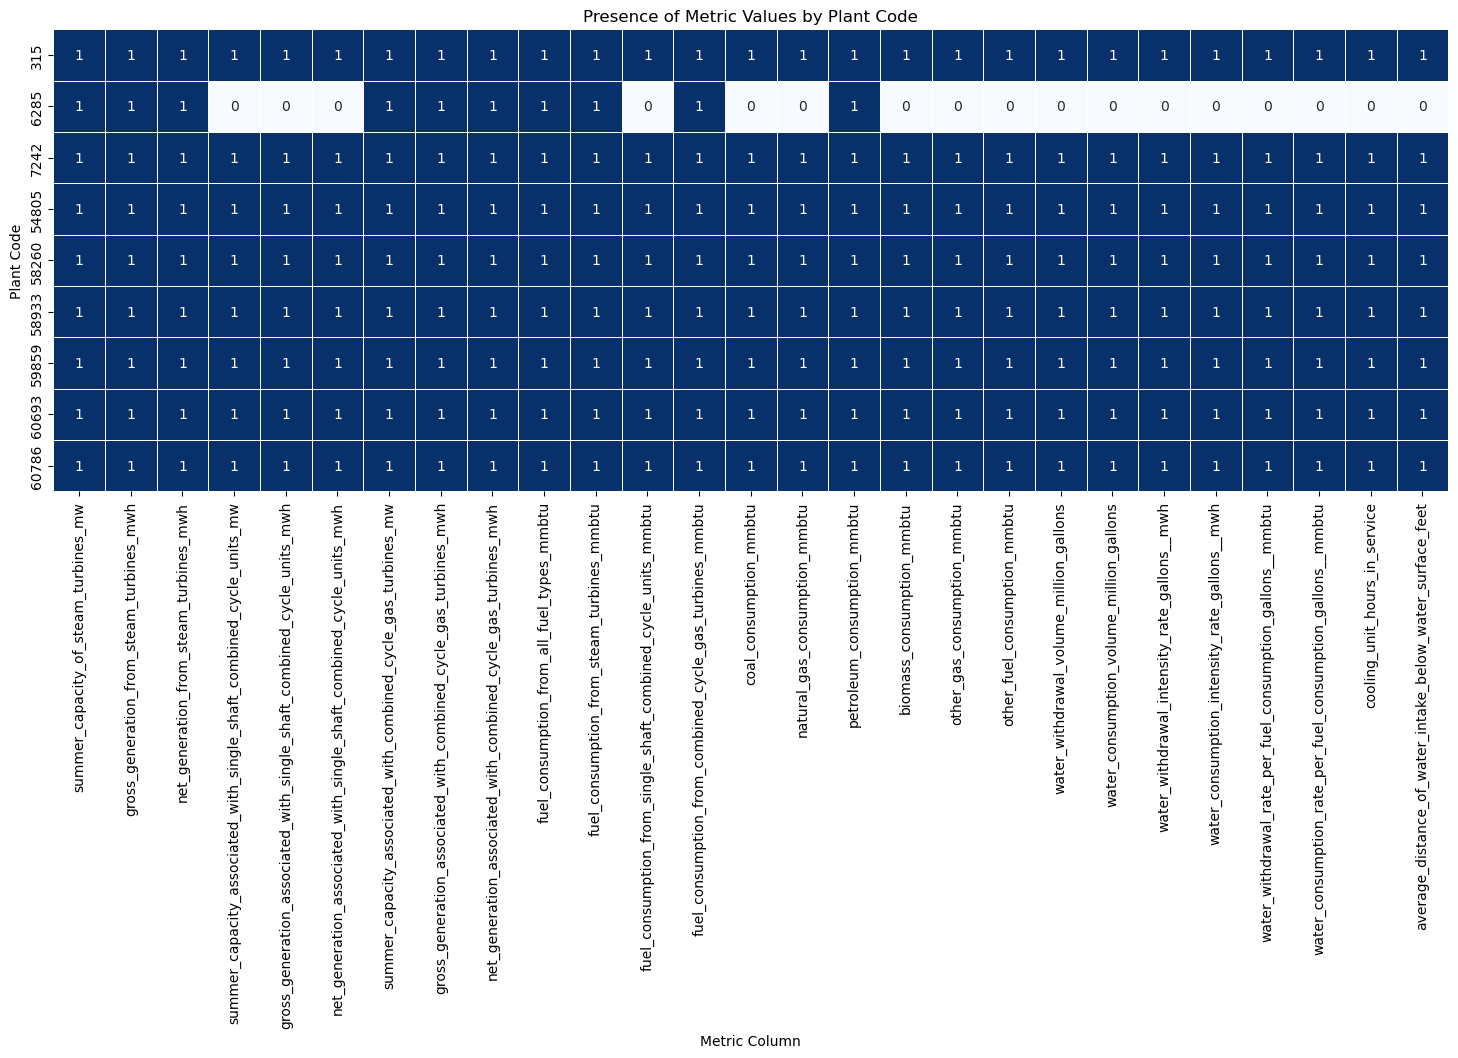

In [266]:
# List Target Plant Codes and Metric Columns

target_plant_codes = [315, 6285, 7242, 54805, 58260, 58933, 59859, 60693, 60786]

metric_columns = [
    'summer_capacity_of_steam_turbines_mw',
    'gross_generation_from_steam_turbines_mwh',
    'net_generation_from_steam_turbines_mwh',
    'summer_capacity_associated_with_single_shaft_combined_cycle_units_mw',
    'gross_generation_associated_with_single_shaft_combined_cycle_units_mwh',
    'net_generation_associated_with_single_shaft_combined_cycle_units_mwh',
    'summer_capacity_associated_with_combined_cycle_gas_turbines_mw',
    'gross_generation_associated_with_combined_cycle_gas_turbines_mwh',
    'net_generation_associated_with_combined_cycle_gas_turbines_mwh',
    'fuel_consumption_from_all_fuel_types_mmbtu',
    'fuel_consumption_from_steam_turbines_mmbtu',
    'fuel_consumption_from_single_shaft_combined_cycle_units_mmbtu',
    'fuel_consumption_from_combined_cycle_gas_turbines_mmbtu',
    'coal_consumption_mmbtu',
    'natural_gas_consumption_mmbtu',
    'petroleum_consumption_mmbtu',
    'biomass_consumption_mmbtu',
    'other_gas_consumption_mmbtu',
    'other_fuel_consumption_mmbtu',
    'water_withdrawal_volume_million_gallons',
    'water_consumption_volume_million_gallons',
    'water_withdrawal_intensity_rate_gallons__mwh',
    'water_consumption_intensity_rate_gallons__mwh',
    'water_withdrawal_rate_per_fuel_consumption_gallons__mmbtu',
    'water_consumption_rate_per_fuel_consumption_gallons__mmbtu',
    'cooling_unit_hours_in_service',]
     
# import seaborn as sns

gen_boil_cool_missing_heatmap = plt.figure(figsize=(18, 6))
sns.heatmap(summary, annot=True, cbar=False, cmap='Blues', linewidths=.5)
plt.title('Presence of Metric Values by Plant Code')
plt.xlabel('Metric Column')
plt.ylabel('Plant Code')
plt.show()


In [29]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/gen_boil_cool_missingness.png'
gen_boil_cool_missing_heatmap.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/gen_boil_cool_missingness.png


### 👀 Conclusion: Preserve rows with missing equipment_id
All plant_codes with missing equipment IDs still contribute metric values to the dataset—even plant_code 6285, though not across all metrics. Additionally, cooling system configurations vary: a cooling system is defined by a unique combination of generator(s), boiler(s), and cooler(s) at a plant. For these reasons, we will preserve all rows.

To support analysis, we’ll create a new column in cooling_boiler_df called cooling_system_signature. NaN values will be temporarily replaced with 'MISSING', and each row will receive a unique concatenation of plant_code, generator_id, boiler_id, and cooling_id.

## 🪄 New Column: 'cooling_system_signature'

In [32]:
# Replace NaN with 'MISSING' for signature creation
signature_cols = ['plant_code', 'generator_id', 'boiler_id', 'cooling_id']
cooling_boiler_df_signature = cooling_boiler_df[signature_cols].fillna('MISSING').astype(str)

# Create the signature column
cooling_boiler_df['cooling_system_signature'] = (
    cooling_boiler_df_signature['plant_code'] + '_' +
    cooling_boiler_df_signature['generator_id'] + '_' +
    cooling_boiler_df_signature['boiler_id'] + '_' +
    cooling_boiler_df_signature['cooling_id']
)


In [33]:
cooling_boiler_df['cooling_system_signature'].nunique()

7372

In [34]:
cooling_boiler_df['plant_code'].nunique()

1009

### 👀 Note: 7,372 unique components of cooling systems across 1,009 plants, from 2015-2023. 

In [36]:
cooling_boiler_df[['plant_code', 'generator_id', 'boiler_id', 'cooling_id', 'cooling_system_signature']].drop_duplicates().head()


,plant_code,generator_id,boiler_id,cooling_id,cooling_system_signature
0,3,3,3,1-3,3_3_3_1-3
12,3,A3C1,8,U8C,3_A3C1_8_U8C
24,3,A3ST,8,U8C,3_A3ST_8_U8C
36,3,1,1,1-3,3_1_1_1-3
48,3,2,2,1-3,3_2_2_1-3


In [37]:
# Checking whether NaN equipment_ids were included. 

# Filter for rows where generator_id is NaN
subset = cooling_boiler_df[cooling_boiler_df['generator_id'].isna()]

# View the relevant columns and check the signature
print(subset[['plant_code', 'generator_id', 'boiler_id', 'cooling_id', 'cooling_system_signature']].head())


       plant_code generator_id boiler_id cooling_id cooling_system_signature
34860        7242          NaN        1B       RC01     7242_MISSING_1B_RC01
34861        7242          NaN        1B       RC01     7242_MISSING_1B_RC01
34862        7242          NaN        1B       RC01     7242_MISSING_1B_RC01
34863        7242          NaN        1B       RC01     7242_MISSING_1B_RC01
34864        7242          NaN        1B       RC01     7242_MISSING_1B_RC01


## 🪄 New Column: 'date'
Creating a single date column from separate year and month columns is good practice because it standardizes the data into a proper datetime format, enabling easier time-based filtering, sorting, and analysis. It also unlocks pandas’ powerful date/time functions and improves data consistency and readability.

In [39]:
cooling_boiler_df['date'] = pd.to_datetime(
    cooling_boiler_df['year'].astype(str) + '-' +
    cooling_boiler_df['month'].astype(str) + '-01'
)


# 🧱 Step 3 – Consolidation & Structural Cleaning

### Goal: 
- Clarify domain-specific technical columns by aligning terminology and structure
- Generate helper "readable" columns mapped from EIA codes
- Derive higher-level groupings (e.g. generator type, cooling system configuration) for interpretability and downstream analysis
- Finalize column data types for PostgreSQL compatibility and seamless upload to pgAdmin

In [41]:
# Specify your list of columns
cols_of_interest = ['generator_primary_technology','cooling_type_1_860', 'cooling_type_2_860', 'cooling_type_923', 'cooling_system_type', 
                    'water_type', 'water_source', 'water_source_name', 'water_discharge_name', 'generator_status', 
                    'boiler_status', 'cooling_status', 'combined_heat_and_power_generator', 'generator_primary_energy_source_code', 
                    'generator_prime_mover_code', 'generator_duct_burners', 'sector', 'steam_plant_type', 'number_operable_generators', 
                    'number_operable_boilers', 'number_operable_cooling_systems', 'relationship_type']  

# Count of missing values per selected column
missing_count = cooling_boiler_df[cols_of_interest].isnull().sum()

# Percentage of missing values per selected column
missing_percentage = (missing_count / len(cooling_boiler_df)) * 100

# Combine into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
})

# Display the summary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_summary.to_string())


                                      Missing Count  Missing Percentage
generator_primary_technology                    336            0.044711
cooling_type_1_860                            63024            8.386427
cooling_type_2_860                           732624           97.488224
cooling_type_923                             172014           22.889421
cooling_system_type                           62460            8.311377
water_type                                   109560           14.578842
water_source                                 109764           14.605988
water_source_name                            107028           14.241916
water_discharge_name                         210300           27.984032
generator_status                                336            0.044711
boiler_status                                   336            0.044711
cooling_status                                62508            8.317764
combined_heat_and_power_generator               528            0

In [42]:
cooling_boiler_df[['generator_primary_technology', 'combined_heat_and_power_generator', 'generator_primary_energy_source_code', 
                   'generator_prime_mover_code', 'generator_duct_burners', 'steam_plant_type']].drop_duplicates().head()

,generator_primary_technology,combined_heat_and_power_generator,generator_primary_energy_source_code,generator_prime_mover_code,generator_duct_burners,steam_plant_type
0,Conventional Steam Coal,N,BIT,ST,NaN,1.0
12,Natural Gas Fired Combined Cycle,N,NG,CT,NaN,1.0
24,Natural Gas Fired Combined Cycle,N,NG,CA,Y,1.0
36,Natural Gas Steam Turbine,N,NG,ST,NaN,1.0
228,Natural Gas Steam Turbine,Y,NG,ST,NaN,1.0


# Exploring relationship between 'generator_primary_technology', 'generator_primary_energy_source_code', and 'generator_prime_mover_code'

In [44]:
cooling_boiler_df['generator_primary_technology'].value_counts(dropna=False)

generator_primary_technology
Natural Gas Fired Combined Cycle               434736
Conventional Steam Coal                        166896
Natural Gas Steam Turbine                       79140
Wood/Wood Waste Biomass                         22764
Nuclear                                         14952
Petroleum Liquids                               13704
Other Gases                                     12384
Other Waste Biomass                              1344
Petroleum Coke                                   1164
Solar Thermal without Energy Storage              984
Coal Integrated Gasification Combined Cycle       876
Municipal Solid Waste                             864
Solar Thermal with Energy Storage                 648
All Other                                         372
NaN                                               336
Natural Gas Fired Combustion Turbine              168
Landfill Gas                                      168
Name: count, dtype: int64

In [45]:
cooling_boiler_df['generator_primary_energy_source_code'].value_counts(dropna=False)

generator_primary_energy_source_code
NG     514044
BIT     98784
SUB     55260
BLQ     20256
NUC     14952
RFO     11496
RC      10140
BFG      8748
OG       3636
WDS      2508
LIG      2316
DFO      1968
SUN      1632
AB       1296
PC        864
MSW       864
SGC       792
WC        480
NaN       336
SGP       300
WO        240
PUR       216
LFG       168
WH         84
TDF        72
OBS        48
Name: count, dtype: int64

In [46]:
cooling_boiler_df['generator_prime_mover_code'].value_counts(dropna=False)

generator_prime_mover_code
ST     312684
CT     296748
CA     133884
CS       6732
CP        648
NaN       336
CC        300
GT        168
Name: count, dtype: int64

## How Electricity is Generated in Power Plants

Electricity is generated when a **large coil of wire spins within a magnetic field inside a generator**. The spinning mechanism-a **turbine**-is mechanically connected to the generator and provides the rotational energy needed for electricity production.

### How the Turbine is Set in Motion

- In most power plants, **fuel is used to produce heat**, which is then used to set the turbine in motion.
    - Typically, this heat **boils water to create high-pressure steam**, which spins the turbine blades.
    - **Fossil fuel plants** burn coal, natural gas, or oil to generate this heat.
    - **Nuclear plants** use energy from nuclear fission to produce heat.
- In contrast, **hydroelectric and wind plants do not rely on heat**:
    - They use **moving water or wind to directly spin the turbine**.
    - The goal remains the same: **to rotate the turbine and drive the generator**.

## Next steps: 
The column generator_primary_technology appears to be an internally derived field used by the EIA to categorize generators based on combinations of fuel types (generator_primary_energy_source_code) and the specific mechanical technology used to convert fuel to energy (generator_prime_mover_code).

To enhance clarity, we will create two new columns: generator_fuel_type and generator_prime_mover, each containing descriptive labels mapped from the corresponding EIA codes. Afterward, we will review the EIA’s primary technology classification scheme for further insights.

In [48]:
# Mapping dictionary with code prefixes
fuel_type_map = {
    'AB': '(AB) Agricultural By-Products',
    'ANT': '(ANT) Anthracite Coal',
    'BFG': '(BFG) Blast Furnace Gas',
    'BIT': '(BIT) Bituminous Coal',
    'BLQ': '(BLQ) Black Liquor',
    'DFO': '(DFO) Distillate Fuel Oil',
    'GEO': '(GEO) Geothermal',
    'H2': '(H2) Hydrogen',
    'JF': '(JF) Jet Fuel',
    'KER': '(KER) Kerosene',
    'LFG': '(LFG) Landfill Gas',
    'LIG': '(LIG) Lignite Coal',
    'MSB': '(MSB) Biogenic Municipal Solid Waste',
    'MSN': '(MSN) Non-biogenic Municipal Solid Waste',
    'MWH': '(MWH) Electricity used for energy storage',
    'NG': '(NG) Natural Gas',
    'NUC': '(NUC) Nuclear',
    'OBG': '(OBG) Other Biomass Gas',
    'OBL': '(OBL) Other Biomass Liquids',
    'OBS': '(OBS) Other Biomass Solids',
    'OG': '(OG) Other Gas',
    'OTH': '(OTH) Other Fuel',
    'PC': '(PC) Petroleum Coke',
    'PGG': '(PGG) Gaseous Propane',
    'PUR': '(PUR) Purchased Steam',
    'RC': '(RC) Refined Coal',
    'RFO': '(RFO) Residual Fuel Oil',
    'SCC': '(SCC) Coal-based Synfuel',
    'SGC': '(SGC) Coal-Derived Synthesis Gas',
    'SGP': '(SGP) Synthesis Gas from Petroleum Coke',
    'SLW': '(SLW) Sludge Waste',
    'SUB': '(SUB) Subbituminous Coal',
    'SUN': '(SUN) Solar',
    'TDF': '(TDF) Tire-derived Fuels',
    'WAT': '(WAT) Water',
    'WC': '(WC) Waste/Other Coal',
    'WDL': '(WDL) Wood Waste Liquids',
    'WDS': '(WDS) Wood/Wood Waste Solids',
    'WH': '(WH) Waste Heat',
    'WND': '(WND) Wind',
    'WOW': '(WOW) Waste/Other Oil',
    'WO': '(WO) Waste Oil',
    'MSW': '(MSW) Municipal Solid Waste (Unspecified Biogenic/Non-Biogenic)'
}

# Revised mapping with NaN preservation
cooling_boiler_df['generator_fuel_type'] = (
    cooling_boiler_df['generator_primary_energy_source_code']
    .map(lambda x: fuel_type_map.get(x) if pd.notna(x) else np.nan)
)

# Validation check
print("Missing fuel type codes (NaN):", cooling_boiler_df['generator_fuel_type'].isna().sum())



Missing fuel type codes (NaN): 336


In [49]:
# Updated prime mover mapping with code prefixes
prime_mover_map = {
    'BA': '(BA) Energy Storage, Battery',
    'BT': '(BT) Turbines Used in a Binary Cycle (Geothermal)',
    'CA': '(CA) Combined-Cycle -- Steam Part',
    'CE': '(CE) Energy Storage, Compressed Air',
    'CP': '(CP) Energy Storage, Concentrated Solar Power',
    'CS': '(CS) Combined-Cycle Single-Shaft',
    'CT': '(CT) Combined-Cycle Combustion Turbine Part',
    'ES': '(ES) Energy Storage, Other',
    'FC': '(FC) Fuel Cell',
    'FW': '(FW) Energy Storage, Flywheel',
    'GT': '(GT) Combustion (Gas) Turbine',
    'HA': '(HA) Hydrokinetic, Axial Flow Turbine',
    'HB': '(HB) Hydrokinetic, Wave Buoy',
    'HK': '(HK) Hydrokinetic, Other',
    'HY': '(HY) Hydraulic Turbine',
    'IC': '(IC) Internal Combustion Engine',
    'PS': '(PS) Energy Storage, Reversible Hydraulic Turbine',
    'OT': '(OT) Other',
    'ST': '(ST) Steam Turbine',
    'PV': '(PV) Photovoltaic',
    'WT': '(WT) Wind Turbine, Onshore',
    'WS': '(WS) Wind Turbine, Offshore',
    'CC': '(CC) Combined-Cycle (Generic)'
}

# Revised mapping with NaN preservation
cooling_boiler_df['generator_prime_mover'] = (
    cooling_boiler_df['generator_prime_mover_code']
    .map(lambda x: prime_mover_map.get(x) if pd.notna(x) else np.nan)
)

# Validation check
print("Missing prime mover codes (NaN):", cooling_boiler_df['generator_prime_mover'].isna().sum())



Missing prime mover codes (NaN): 336


## Grouped Frequency Table: Generator Tech

In [51]:
# Count occurrences of each combination
detailed = (
    cooling_boiler_df.groupby(['generator_primary_technology', 'generator_fuel_type', 'generator_prime_mover'])
      .size()
      .reset_index(name='count')
)

display(detailed)


,generator_primary_technology,generator_fuel_type,generator_prime_mover,count
0,All Other,(PUR) Purchased Steam,(ST) Steam Turbine,216
1,All Other,(TDF) Tire-derived Fuels,(ST) Steam Turbine,72
2,All Other,(WH) Waste Heat,(CA) Combined-Cycle -- Steam Part,84
3,Coal Integrated Gasification Combined Cycle,(BIT) Bituminous Coal,(CA) Combined-Cycle -- Steam Part,84
4,Coal Integrated Gasification Combined Cycle,(SGC) Coal-Derived Synthesis Gas,(CA) Combined-Cycle -- Steam Part,216
5,Coal Integrated Gasification Combined Cycle,(SGC) Coal-Derived Synthesis Gas,(CT) Combined-Cycle Combustion Turbine Part,576
6,Conventional Steam Coal,(BIT) Bituminous Coal,(ST) Steam Turbine,98700
7,Conventional Steam Coal,(LIG) Lignite Coal,(ST) Steam Turbine,2316
8,Conventional Steam Coal,(RC) Refined Coal,(ST) Steam Turbine,10140
9,Conventional Steam Coal,(SUB) Subbituminous Coal,(ST) Steam Turbine,55260


## New Column: `gen_tech_signature`

While we retain the `generator_primary_technology` column for compatibility with the EIA’s internal documentation and analytical standards, we also introduce a new column: `gen_tech_signature`. This signature is created by concatenating the generator’s fuel type and prime mover. 

The purpose of `gen_tech_signature` is to provide a more granular and transparent representation of each generator’s technology configuration. By capturing both the fuel source and the mechanical technology used, this column enables more flexible grouping, analysis, and comparison across different plant types-especially in cases where the standard EIA technology categories may be too broad or ambiguous for our specific analytical needs.


In [53]:
# Replace NaN with 'MISSING' for signature creation
signature_cols = ['generator_fuel_type', 'generator_prime_mover']
cooling_boiler_df_signature = cooling_boiler_df[signature_cols].fillna('MISSING').astype(str)

# Create the signature column
cooling_boiler_df['gen_tech_signature'] = (
    cooling_boiler_df_signature['generator_fuel_type'] + '_' +
    cooling_boiler_df_signature['generator_prime_mover']
)


In [54]:
# Checking whether NaN equipment_ids were included. 

# Filter for rows where generator_id is NaN
subset_1 = cooling_boiler_df[cooling_boiler_df['generator_fuel_type'].isna()]

# View the relevant columns and check the signature
print(subset_1[['plant_code', 'generator_primary_technology', 'generator_fuel_type', 'generator_prime_mover', 'gen_tech_signature']].head())


       plant_code generator_primary_technology generator_fuel_type  \
34860        7242                          NaN                 NaN   
34861        7242                          NaN                 NaN   
34862        7242                          NaN                 NaN   
34863        7242                          NaN                 NaN   
34864        7242                          NaN                 NaN   

      generator_prime_mover gen_tech_signature  
34860                   NaN    MISSING_MISSING  
34861                   NaN    MISSING_MISSING  
34862                   NaN    MISSING_MISSING  
34863                   NaN    MISSING_MISSING  
34864                   NaN    MISSING_MISSING  


In [55]:
subset_1.shape

(336, 73)

In [56]:
cooling_boiler_df['gen_tech_signature'].nunique()

41

In [57]:
cooling_boiler_df['combined_heat_and_power_generator'].value_counts(dropna=False)

combined_heat_and_power_generator
N      567828
Y      183144
NaN       528
Name: count, dtype: int64

# Combined Heat and Power Generators (CHP) & Generator Duct Burners

**Combined Heat and Power (CHP) generators**-also known as cogeneration plants-are equipped with systems that **recover waste heat** from the electricity generation process. Instead of expelling this heat through cooling towers or releasing it into the environment, CHP plants capture and utilize the thermal energy for heating buildings, providing hot water, or supporting industrial processes. This approach reduces the amount of fuel needed for separate heating, lowers demand on cooling systems, saves operational costs, and cuts emissions.

**Generator Duct Burners**  
**Duct burners** are devices commonly found in combined-cycle power plants. In these plants, a gas-fueled combustion turbine acts as the primary electricity generator. The hot exhaust from this turbine passes through a **heat recovery steam generator (HRSG)**, which uses the exhaust heat to produce additional steam for generating more electricity. When a duct burner is installed between the combustion turbine and the HRSG, it can burn extra fuel (usually natural gas) to further raise the temperature of the exhaust gases, thereby increasing steam production in the HRSG. Duct burners are especially useful during periods of high electricity demand, as they provide extra generation capacity and operational flexibility-allowing the plant to respond quickly to market needs or compensate for lost steam if part of the plant goes offline. The trade-off is increased fuel consumption and emissions.


## Changing to Boolean Format

The original values in the `combined_heat_and_power_generator` column and `generator_duct_burners` were `'Y'` and `'N'`, indicating the presence or absence of a feature. However, these string values are not natively supported as Boolean types in SQL, and they are not ideal for machine learning workflows, which require numeric inputs.

To address this:

- We converted `'Y'` to `1` and `'N'` to `0` to align with standard Boolean logic.
- This transformation ensures compatibility with both SQL databases (where Boolean or integer types are preferred) and machine learning models, which require numeric formats.
- Missing values (`NaN`) were preserved to allow for potential analysis of missingness patterns.

This approach balances data integrity with flexibility for both analysis and modeling tasks.


In [60]:
# STEP 1: Map Y/N to Boolean-friendly values
cooling_boiler_df['combined_heat_and_power_generator'] = cooling_boiler_df['combined_heat_and_power_generator'].map({
    'Y': 1,
    'N': 0
})


In [61]:
cooling_boiler_df['combined_heat_and_power_generator'].value_counts(dropna=False)

combined_heat_and_power_generator
0.0    567828
1.0    183144
NaN       528
Name: count, dtype: int64

In [62]:
# STEP 2: Map Y/N to Boolean-friendly values
cooling_boiler_df['generator_duct_burners'] = cooling_boiler_df['generator_duct_burners'].map({
    'Y': 1,
    'N': 0
})


In [63]:
cooling_boiler_df['generator_duct_burners'].value_counts(dropna=False)

generator_duct_burners
NaN    610104
1.0    102132
0.0     39264
Name: count, dtype: int64

# Cooling System Design Types 

## Cooling System Designs in Power Plants

Cooling systems in power plants are essential for regulating equipment temperature and maintaining thermal efficiency. Electricity generation relies on a temperature gradient—specifically, the difference between the heat source (e.g., steam) and the cooler environment. Effective cooling is thus critical to sustaining this gradient and ensuring efficient operation.

Cooling system design varies based on both **technological** and **geographical** factors:

- **Prime mover technology** (e.g., nuclear, gas, coal) influences the type and intensity of cooling needed.
- **Local water availability** is often the decisive factor. For example:
  - **Dry cooling** systems, which rely on air and large fans, are often used in arid regions to minimize water use.
  - **Recirculating systems** (e.g., cooling ponds or towers) reduce total water withdrawal but require ample land.
  - **Once-through systems** withdraw large volumes of water and return it at elevated temperatures, which can affect local ecosystems.

While many plants **return most of the water they withdraw**, water is often returned **at higher temperatures**, impacting aquatic life and surrounding habitats.

Understanding cooling system types—especially when linked with variables like `water_type` and `water_source`—is key to analyzing the **water-energy nexus** and assessing **water stewardship** in the power sector.


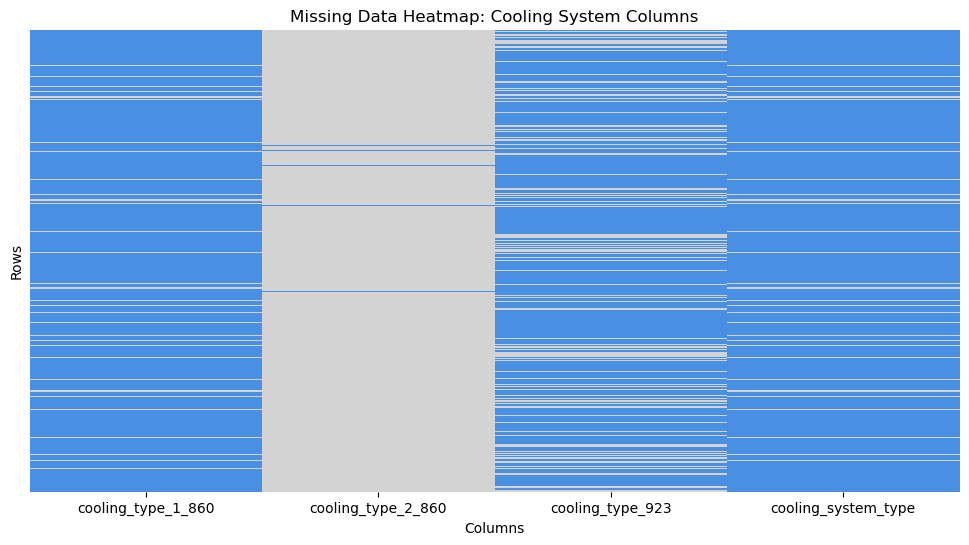

In [66]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from matplotlib.colors import ListedColormap

# List of columns to visualize
cols = ['cooling_type_1_860', 'cooling_type_2_860', 'cooling_type_923', 'cooling_system_type']

# Select only those columns
subset_df = cooling_boiler_df[cols]  # or use .loc[:, cols]

# Create a boolean DataFrame: True for missing, False for present
missing_mask = subset_df.isnull()

# Define custom colors: soft blue for present (False), light gray for missing (True)
colors = ["#4A90E2", "#D3D3D3"]  # blue, gray
cmap = ListedColormap(colors)

missing_cooling_heatmap = plt.figure(figsize=(12, 6))
sns.heatmap(
    missing_mask,
    cmap=cmap,
    cbar=False,
    yticklabels=False  # Hide row labels for clarity
)
plt.title("Missing Data Heatmap: Cooling System Columns")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


In [67]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/missing_cooling_heatmap.png'
missing_cooling_heatmap.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/missing_cooling_heatmap.png


In [68]:
cooling_boiler_df[['cooling_type_1_860', 'cooling_type_2_860', 'cooling_type_923', 'cooling_system_type']].drop_duplicates().head(10)

,cooling_type_1_860,cooling_type_2_860,cooling_type_923,cooling_system_type
0,(ON) Once through No Cool Pond,NaN,ON,Open
12,(RI) Recirculate: Induced Draft,NaN,NaN,Closed
84,(RI) Recirculate: Induced Draft,NaN,RI,Closed
252,(ON) Once through No Cool Pond,NaN,NaN,Open
444,(ON) Once through No Cool Pond,OT,ON,Other
792,(RC) Recirculate: Cooling Pond,NaN,RC,Closed
1068,NaN,NaN,RI,NaN
1218,(RN) Recirculate: Natural Draft,NaN,RN,Closed
1644,(ON) Once through No Cool Pond,OC,NaN,Open
1656,(ON) Once through No Cool Pond,OC,ON,Open


### Notes:

- `cooling_type_1_860` and `cooling_type_2_860` record the **primary and secondary cooling system designs**, respectively. These are sourced from **EIA Form 860**, which focuses on plant-level **design and infrastructure** characteristics.
  
- `cooling_type_923` comes from **EIA Form 923**, which tracks **monthly operational data**. This field reflects the cooling system configuration in practice, based on how the plant actually operated during the reporting period.

- `cooling_system_type` is a **higher-level, standardized classification** developed by EIA analysts. It synthesizes information from the three aforementioned columns (`cooling_type_1_860`, `cooling_type_2_860`, and `cooling_type_923`) to create a more uniform descriptor of the plant’s cooling approach, especially useful for cross-cutting analysis and internal consistency.

### Next Steps

- **Map EIA Codes to Descriptions**  
  Create clear, human-readable mappings for the categorical codes in:
  - `cooling_type_2_860`
  - `cooling_type_923`  
  This will improve interpretability and support downstream analysis and documentation.

- **Create Grouped Frequency Table View for `cooling_system_type`**  
  As with `generator_primary_technology` earlier, generate a pivot table or summary view to explore:
  - How `cooling_system_type` relates to the combinations of `cooling_type_1_860`, `cooling_type_2_860`, and `cooling_type_923`
  - Which technical configurations map to which high-level classifications  
  This will help validate the consistency and usefulness of the `cooling_system_type` field.


In [70]:
cooling_boiler_df['cooling_type_2_860'].value_counts(dropna=False)

cooling_type_2_860
NaN    732624
RI       8724
HT       5112
RC       2088
ON       1728
OT        972
OC        228
HRI        24
Name: count, dtype: int64

In [71]:
cooling_boiler_df['cooling_type_923'].value_counts(dropna=False)

cooling_type_923
RI     338644
NaN    172014
ON     123581
RC      46320
DC      38363
RN      17064
OC       9132
HRI      2152
RF       2082
OT       1992
HRF       144
RE         12
Name: count, dtype: int64

In [72]:
# Master cooling type mapping from both 860 and 923
cooling_map = {
    'RI': '(RI) Recirculate: Induced Draft',
    'ON': '(ON) Once through No Cool Pond',
    'RC': '(RC) Recirculate: Cooling Pond',
    'DC': '(DC) Dry Cooling',
    'RN': '(RN) Recirculate: Natural Draft',
    'OC': '(OC) Once through with Cool Pond',
    'RF': '(RF) Recirculate: Forced Draft',
    'OT': '(OT) Other',
    'HRI': '(HRI) Hybrid: Dry / Induced Draft',
    'HRF': '(HRF) Hybrid: Dry / Forced Draft',
    'HT': '(HT) Hybrid Tower',
    'RE': '(RE) Recirculate: Evaporative',
    'NC': '(NC) Non-Contact Cooling'
}

# Apply mapping to both columns
cooling_boiler_df['cooling_type_2_860'] = cooling_boiler_df['cooling_type_2_860'].map(cooling_map)
cooling_boiler_df['cooling_type_923'] = cooling_boiler_df['cooling_type_923'].map(cooling_map)



In [73]:
cooling_boiler_df['cooling_type_2_860'].value_counts(dropna=False)

cooling_type_2_860
NaN                                  732624
(RI) Recirculate: Induced Draft        8724
(HT) Hybrid Tower                      5112
(RC) Recirculate: Cooling Pond         2088
(ON) Once through No Cool Pond         1728
(OT) Other                              972
(OC) Once through with Cool Pond        228
(HRI) Hybrid: Dry / Induced Draft        24
Name: count, dtype: int64

In [74]:
cooling_boiler_df['cooling_type_923'].value_counts(dropna=False)

cooling_type_923
(RI) Recirculate: Induced Draft      338644
NaN                                  172014
(ON) Once through No Cool Pond       123581
(RC) Recirculate: Cooling Pond        46320
(DC) Dry Cooling                      38363
(RN) Recirculate: Natural Draft       17064
(OC) Once through with Cool Pond       9132
(HRI) Hybrid: Dry / Induced Draft      2152
(RF) Recirculate: Forced Draft         2082
(OT) Other                             1992
(HRF) Hybrid: Dry / Forced Draft        144
(RE) Recirculate: Evaporative            12
Name: count, dtype: int64

## Grouped Frequency Table: Cooling System Design

In [76]:
cooling_boiler_df['cooling_system_type'].value_counts(dropna=False)

cooling_system_type
Closed        444258
Open          189972
NaN            62460
Dry/Hybrid     44448
Other          10362
Name: count, dtype: int64

In [77]:
detailed_2 = (
    cooling_boiler_df
    .fillna({'cooling_type_1_860': 'Missing', 'cooling_type_2_860': 'Missing', 'cooling_type_923': 'Missing'})
    .groupby(['cooling_system_type', 'cooling_type_1_860', 'cooling_type_2_860', 'cooling_type_923'])
    .size()
    .reset_index(name='count')
)
detailed_2

,cooling_system_type,cooling_type_1_860,cooling_type_2_860,cooling_type_923,count
0,Closed,(RC) Recirculate: Cooling Pond,(HT) Hybrid Tower,(RC) Recirculate: Cooling Pond,420
1,Closed,(RC) Recirculate: Cooling Pond,(HT) Hybrid Tower,(RI) Recirculate: Induced Draft,72
2,Closed,(RC) Recirculate: Cooling Pond,(RI) Recirculate: Induced Draft,(RC) Recirculate: Cooling Pond,2856
3,Closed,(RC) Recirculate: Cooling Pond,(RI) Recirculate: Induced Draft,(RI) Recirculate: Induced Draft,96
4,Closed,(RC) Recirculate: Cooling Pond,(RI) Recirculate: Induced Draft,Missing,360
5,Closed,(RC) Recirculate: Cooling Pond,Missing,(RC) Recirculate: Cooling Pond,39384
6,Closed,(RC) Recirculate: Cooling Pond,Missing,(RI) Recirculate: Induced Draft,36
7,Closed,(RC) Recirculate: Cooling Pond,Missing,Missing,4224
8,Closed,(RF) Recirculate: Forced Draft,Missing,(RF) Recirculate: Forced Draft,2010
9,Closed,(RF) Recirculate: Forced Draft,Missing,(RI) Recirculate: Induced Draft,192


## Cooling Type Mismatch Flag

The columns `cooling_type_1_860` and `cooling_type_923` represent two different perspectives on a plant's cooling system:

- **`cooling_type_1_860`**: Captures the **installed cooling system** as reported in **EIA Form 860**, which is submitted **annually** and reflects the plant’s **physical infrastructure** (i.e., what is built and available).
- **`cooling_type_923`**: Captures the **operational cooling system** in use during the year, based on **EIA Form 923**, which is submitted **monthly** and reflects **how the plant actually operated**.

This distinction highlights the difference between **design** (what's built) and **operation** (what's used in practice). Mismatches between the two columns may arise due to:
- Use of **backup or hybrid systems** that aren’t captured in static design data
- **Operational flexibility** in response to water availability, ambient temperature, maintenance, or policy constraints
- **Timing mismatches**, especially when infrastructure is upgraded or changed mid-year
- Or simply **reporting inconsistencies or data entry errors**

To track this, we created a Boolean `cooling_type_mismatch` flag to indicate where the installed and operational systems differ. This helps identify patterns or anomalies in water use, system performance, or reporting behavior.

> 💡 *Note: The water withdrawal and consumption data in the `cooling_boiler_detail` dataset originates from **EIA Form 923**, and thus reflects actual cooling system operation-not just the design.*

---

**Addendum:**  
Mismatches might also occur due to **organizational separation**:  
*Form 860 is typically completed by staff responsible for asset management, engineering, or regulatory compliance, while Form 923 is completed by operations staff, reporting on actual, real-world operations and usage each month. This organizational difference is a well-known source of data mismatch in EIA reporting.*


In [79]:
# Cast Boolean to integer (0/1) for better compatibility with SQL databases,
# easier aggregation, and use in modeling workflows.
cooling_boiler_df['cooling_type_mismatch'] = (
    cooling_boiler_df['cooling_type_1_860'] != cooling_boiler_df['cooling_type_923']
).astype(int)


# Closer look at 'cooling_type_923'

In [81]:
missing_water_metrics = cooling_boiler_df[
    cooling_boiler_df['cooling_type_923'].notna() & 
    (
        cooling_boiler_df['water_withdrawal_volume_million_gallons'].isna() | 
        cooling_boiler_df['water_consumption_volume_million_gallons'].isna()
    )
]
print(f"Rows with cooling_type_923 but missing either water metric: {missing_water_metrics.shape[0]}")

Rows with cooling_type_923 but missing either water metric: 24660


In [82]:
missing_water_metrics['cooling_type_923'].value_counts(dropna=False)


cooling_type_923
(ON) Once through No Cool Pond       10928
(DC) Dry Cooling                      7051
(RI) Recirculate: Induced Draft       5342
(RC) Recirculate: Cooling Pond         544
(OC) Once through with Cool Pond       400
(OT) Other                             240
(RN) Recirculate: Natural Draft        104
(HRI) Hybrid: Dry / Induced Draft       51
Name: count, dtype: int64

In [83]:
# Filter Rows Missing Both 
cooling_missing = cooling_boiler_df[
    cooling_boiler_df['cooling_type_1_860'].isna() &
    cooling_boiler_df['cooling_type_923'].isna()
]
print(f"Rows missing both cooling_type_1_860 and cooling_type_923: {cooling_missing.shape[0]}")


Rows missing both cooling_type_1_860 and cooling_type_923: 572


In [84]:
# Of those rows, which have either water metric present
cooling_missing_with_water = cooling_missing[
    cooling_missing['water_withdrawal_volume_million_gallons'].notna() |
    cooling_missing['water_consumption_volume_million_gallons'].notna()
]
print(f"Of those, rows that DO have water metrics: {cooling_missing_with_water.shape[0]}")


Of those, rows that DO have water metrics: 452


### ✅ What We’ve Done:
- Created cooling_type_mismatch — flags mismatches between Form 860 (design) and 923 (operation).
- Discovered missing water metrics in unexpected cooling types (like Once Through and Recirculating).
- Zoomed in on rows missing both cooling_type_1_860 and cooling_type_923, yet still reporting water use (452 rows).

#### Next: 
- Flag rows (note: certain of these rows might still have 'cooling_system_type' data entered, for cross-check)

In [86]:
cooling_boiler_df['unknown_cooling_with_water'] = (
    cooling_boiler_df['cooling_type_1_860'].isna() &
    cooling_boiler_df['cooling_type_923'].isna() &
    (
        cooling_boiler_df['water_withdrawal_volume_million_gallons'].notna() |
        cooling_boiler_df['water_consumption_volume_million_gallons'].notna()
    )
).astype(int)


In [87]:
cooling_boiler_df['unknown_cooling_with_water'].sum()
# Should be 452


452

## Notes: New Column – `cooling_design_signature`

Similar to the `gen_tech_signature` we created for fuel type and prime mover, this column concatenates `cooling_type_1_860` and `cooling_type_2_860`. Each unique pair represents a specifically engineered cooling system design at a given plant.

This signature is useful for aggregation, clustering, and as a categorical feature in machine learning workflows. Additionally, comparing `cooling_design_signature` with `cooling_type_923` (which reflects operational cooling behavior) can reveal discrepancies between designed and practiced cooling systems—highlighting changes over time, seasonal differences, or potential reporting inconsistencies.


In [89]:
cooling_boiler_df['cooling_design_signature'] = (
    cooling_boiler_df['cooling_type_1_860'].fillna('MISSING') + ' | ' +
    cooling_boiler_df['cooling_type_2_860'].fillna('MISSING')
)


## Explore: 'sector', 'steam_plant_type', 'relationship_type'

In [91]:
cooling_boiler_df[['sector', 'steam_plant_type', 'relationship_type']].drop_duplicates().head(10)

,sector,steam_plant_type,relationship_type
0,Electric Utility,1.0,Unoperable
36,Electric Utility,1.0,1C MB MG
252,Electric Utility,4.0,Unoperable
336,Electric Utility,1.0,Simple
348,Electric Utility,1.0,Complex
444,Electric Utility,3.0,1C MB MG
840,Electric Utility,1.0,MC 1B 1G
888,Electric Utility,1.0,1C 1B MG
1668,IPP Non-CHP,3.0,Simple
1704,Electric Utility,3.0,Simple


## Sector Labels Explained

| Label                  | Meaning                                                                                      | Typical Owners/Operators          |
|------------------------|---------------------------------------------------------------------------------------------|-----------------------------------|
| **Electric Utility**   | Traditional, regulated utilities that generate and sell electricity to the public.           | Public utilities, municipal, or investor-owned utilities (IOUs) |
| **IPP Non-CHP**        | Independent Power Producers (IPPs) that generate electricity only (not combined heat/power). | Private companies, not utilities  |
| **Industrial CHP**     | Industrial facilities that use Combined Heat and Power (CHP, or cogeneration) to produce both electricity and useful heat for their own use. | Factories, refineries, large plants |
| **IPP CHP**            | Independent Power Producers that operate Combined Heat and Power plants.                     | Private companies, sometimes selling both electricity and steam/heat |
| **Commercial Non-CHP** | Commercial entities (like office buildings, malls, hospitals) that generate electricity, but not with CHP. | Large commercial facilities       |
| **Industrial Non-CHP** | Industrial facilities that generate electricity for their own use, but not with CHP.         | Factories, manufacturing plants   |
| **NaN**                | Missing or unclassified sector.                                                             | Data not reported or not applicable |

---

### Quick Definitions

- **Electric Utility:**  
  A company or public entity whose primary business is supplying electricity to consumers. They own and operate power plants and the grid.

- **IPP (Independent Power Producer):**  
  A non-utility company that owns/operates facilities to generate electricity for sale to utilities or the wholesale market.  
  - **Non-CHP:** Only electricity, not heat.
  - **CHP:** Both electricity and usable heat.

- **CHP (Combined Heat and Power):**  
  Also called cogeneration. These plants produce both electricity and useful thermal energy (heat/steam).

- **Industrial/Commercial:**  
  Facilities that primarily serve their own needs (factories, office parks, hospitals), sometimes selling excess electricity.

- **NaN:**  
  Data is missing or not classified.

---

### Why It Matters

- **Sector** helps distinguish who owns/operates the plant and for what purpose (public supply, private use, or both).
- **CHP** indicates plants designed for efficiency by using waste heat.
- **IPP vs. Utility:** IPPs are private and compete in wholesale markets; utilities are regulated and serve retail customers.

---

Answer from Perplexity: pplx.ai/share

In [93]:
cooling_boiler_df['sector'].value_counts(dropna=False)

sector
Electric Utility      346939
IPP Non-CHP           229826
Industrial CHP        114126
IPP CHP                58800
NaN                      813
Commercial Non-CHP       768
Industrial Non-CHP       228
Name: count, dtype: int64

## Notes

- `'steam_plant_type'` and `'relationship_type'` are among the attributes with zero missingness in the dataset.
- **`steam_plant_type`** is a high-level categorization of each plant, based on its primary fuel consumption and size (defined by a threshold of electricity generation).
- **`relationship_type`** describes the various configurations of components that make up a unique cooling system. For clarity, this attribute has been renamed to **`configuration_type`**.
- Because the original dataset is granular at the level of individual cooling system components (generator, boiler, cooler), the `configuration_type` information is repeated for each relevant component.


In [95]:
# Define the mapping from numeric codes - labels simplified from EIA Form 860 Technical Documentation
steam_plant_type_labels = {
    1.0: "Large Thermal Combustion Steam Plants (≥100 MW)",
    2.0: "Medium Thermal Combustion Steam Plants (10–99 MW)",
    3.0: "Large Non-Combustion Steam Plants (≥100 MW)",
    4.0: "Non-Steam / Other Generation"
}

# Apply the mapping to create or overwrite the column
cooling_boiler_df["steam_plant_type_full"] = cooling_boiler_df["steam_plant_type"].map(steam_plant_type_labels)


In [96]:
cooling_boiler_df['relationship_type'].value_counts(dropna=False)

relationship_type
1C MB MG      320430
Complex       185763
Unoperable    145261
Simple         66193
1C 1B MG       23483
1C MB 1G        5930
MC 1B MG        2352
MC 1B 1G        1584
MC MB 1G         504
Name: count, dtype: int64

In [97]:
cooling_boiler_df.rename(columns={'relationship_type': 'configuration_type'}, inplace=True)


#### ⚠️ Alert: 
We would not expect “Unoperable” configurations to have associated water metrics. The presence of 24,188 such rows indicates that the dataset’s operational and reporting logic is more complex than anticipated. This finding highlights the need for further investigation and validation in SQL before drawing conclusions about water use and operational status.

In [315]:
# Filter for 'Unoperable' and non-null in either water column
mask = (
    (cooling_boiler_df['configuration_type'] == 'Unoperable') &
    (
        cooling_boiler_df['water_withdrawal_volume_mg'].notna() |
        cooling_boiler_df['water_consumption_volume_mg'].notna()
    )
)

count = mask.sum()
print(f"Number of 'Unoperable' configurations with water data: {count}")


Number of 'Unoperable' configurations with water data: 24188


# 🎰 Equipment metadata

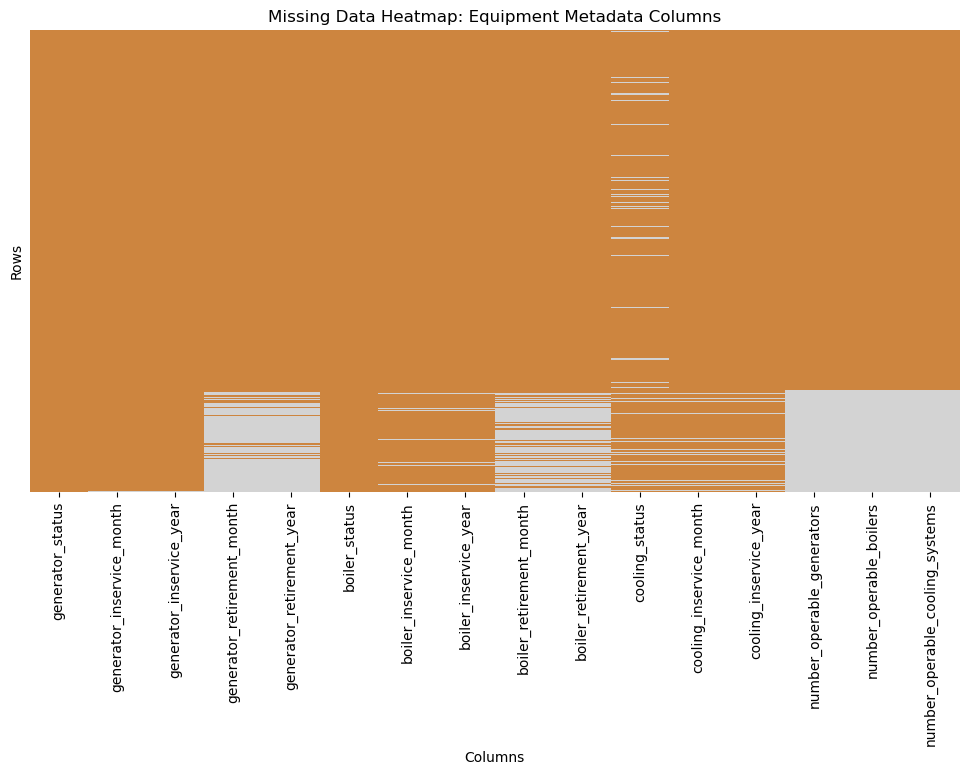

In [99]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from matplotlib.colors import ListedColormap

# List of columns to visualize
cols_1 = ['generator_status', 'generator_inservice_month', 'generator_inservice_year', 'generator_retirement_month', 
                   'generator_retirement_year', 'boiler_status', 'boiler_inservice_month', 'boiler_inservice_year', 'boiler_retirement_month', 
                   'boiler_retirement_year', 'cooling_status', 'cooling_inservice_month', 'cooling_inservice_year', 
                   'number_operable_generators', 'number_operable_boilers', 'number_operable_cooling_systems']

# Select only those columns
subset_df_1 = cooling_boiler_df[cols_1]  # or use .loc[:, cols]

# Create a boolean DataFrame: True for missing, False for present
missing_mask_1 = subset_df_1.isnull()

# Define custom colors: soft blue for present (False), light gray for missing (True)
colors = ["#CD853F", "#D3D3D3"]  # orange, gray
cmap = ListedColormap(colors)

missing_equipment_heatmap = plt.figure(figsize=(12, 6))
sns.heatmap(
    missing_mask_1,
    cmap=cmap,
    cbar=False,
    yticklabels=False  # Hide row labels for clarity
)
plt.title("Missing Data Heatmap: Equipment Metadata Columns")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


In [100]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/missing_equipment_heatmap.png'
missing_equipment_heatmap.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/missing_equipment_heatmap.png


In [101]:
cooling_boiler_df['number_operable_generators'].value_counts(dropna=False)

number_operable_generators
       585840
NaN    165660
Name: count, dtype: int64

In [102]:
cooling_boiler_df['number_operable_boilers'].value_counts(dropna=False)

number_operable_boilers
       585840
NaN    165660
Name: count, dtype: int64

In [103]:
cooling_boiler_df['number_operable_cooling_systems'].value_counts(dropna=False)

number_operable_cooling_systems
       585840
NaN    165660
Name: count, dtype: int64

## Note re: 'number_operable_'
The columns number_operable_generators, number_operable_boilers, and number_operable_cooling_systems appear to be either aspirational (intended for future use but not populated) or the result of an incomplete attempt to derive operable component counts from status fields. Due to the prevalence of blank and NaN values, these columns should be treated as unreliable for analysis unless their derivation can be confirmed.
As such, they will be removed from the dataset prior to importing into SQL.

In [280]:
# Remove unwanted columns
cols_to_drop = ['number_operable_generators', 'number_operable_boilers', 'number_operable_cooling_sytems']
cooling_boiler_df = cooling_boiler_df.drop(columns=[col for col in cols_to_drop if col in cooling_boiler_df.columns])


In [184]:
cooling_boiler_df[['cooling_system_signature', 'month', 'year', 'generator_status', 'generator_inservice_month', 'generator_inservice_year', 
                   'generator_retirement_month', 'generator_retirement_year', 'boiler_status', 'boiler_inservice_month', 
                   'boiler_inservice_year', 'boiler_retirement_month', 'boiler_retirement_year', 'cooling_status', 
                   'cooling_inservice_month', 'cooling_inservice_year', 'cooling_design_signature' ]].head(50)

,cooling_system_signature,month,year,generator_status,generator_inservice_month,generator_inservice_year,generator_retirement_month,generator_retirement_year,boiler_status,boiler_inservice_month,boiler_inservice_year,boiler_retirement_month,boiler_retirement_year,cooling_status,cooling_inservice_month,cooling_inservice_year,cooling_design_signature
0,3_3_3_1-3,1,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
1,3_3_3_1-3,2,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
2,3_3_3_1-3,3,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
3,3_3_3_1-3,4,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
4,3_3_3_1-3,5,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
5,3_3_3_1-3,6,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
6,3_3_3_1-3,7,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
7,3_3_3_1-3,8,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
8,3_3_3_1-3,9,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING
9,3_3_3_1-3,10,2023,RE,7,1959,8,2015,RE,7,1959,8,2015,OP,2,1954,(ON) Once through No Cool Pond | MISSING


In [180]:
# Export data to csv
path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7'
output_file = 'cooling_boiler_df_FINAL.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
cooling_boiler_df.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'cooling_boiler_df_FINAL.csv' has been created successfully.


## Epiphanies re: Equipment Metadata — 'Inservice Month' and 'Inservice Year'

Closer investigation reveals that the concatenated signature for cooling systems is **not sufficiently granular** enough. For example, the signature `3_3_3_1-3` appears **twice** in 2023, once for each generator, because it actually involves **two distinct physical generators and boilers**, each with its own inservice timeline.

- The **1959 generator** was retired (RE) in 2023.
- The **1954 generator** remains operational (OP) in 2023.

Therefore, if we were to aggregate the dataset by **unique cooling system configurations** throughout the evolution of a plant from 2015–2023 (i.e., all different cooling systems involved, regardless of whether they still exist in 2023), we would need to create a composite key that indexes the **cooling system signature** along with the respective **generator**, **boiler**, and **cooling system inservice month and year**.

**Translation**: Our cooling system key isn’t sufficient. We need a more granular key to handle the historical evolution of system components...and brace ourselves for even more time-consuming joins. 😭


In [238]:
cooling_boiler_df["cooling_system_signature_full"] = (
    cooling_boiler_df["cooling_system_signature"].fillna("MISSING").astype(str) + "|" +
    cooling_boiler_df["generator_inservice_month"].fillna("MISSING").astype(str) + "|" +
    cooling_boiler_df["generator_inservice_year"].fillna("MISSING").astype(str) + "|" +
    cooling_boiler_df["boiler_inservice_month"].fillna("MISSING").astype(str) + "|" +
    cooling_boiler_df["boiler_inservice_year"].fillna("MISSING").astype(str) + "|" +
    cooling_boiler_df["cooling_inservice_month"].fillna("MISSING").astype(str) + "|" +
    cooling_boiler_df["cooling_inservice_year"].fillna("MISSING").astype(str)
)


In [240]:
cooling_boiler_df['cooling_system_signature_full'].nunique()

14899

In [244]:
# Step 1: Group by year and cooling_system_signature_full
grouped = cooling_boiler_df.groupby(['year', 'cooling_system_signature_full'])

# Step 2: Count the number of unique generator_status entries per group
status_counts = grouped['generator_status'].nunique().reset_index()

# Step 3: Filter to where there's more than one unique generator_status
status_conflict = status_counts[status_counts['generator_status'] > 1]

# Step 4: Count unique cooling_system_signature_FULL entries
num_conflicting_signatures = status_conflict['cooling_system_signature_full'].nunique()

print("Number of unique cooling_system_signature_FULL with >1 generator_status in a year:", num_conflicting_signatures)


Number of unique cooling_system_signature_FULL with >1 generator_status in a year: 0


In [246]:
# Step 1: Group by year and cooling_system_signature_FULL
grouped_2 = cooling_boiler_df.groupby(['year', 'cooling_system_signature_full'])

# Step 2: Count the number of unique generator_status entries per group
status_counts_2 = grouped_2['boiler_status'].nunique().reset_index()

# Step 3: Filter to where there's more than one unique generator_status
status_conflict_2 = status_counts_2[status_counts_2['boiler_status'] > 1]

# Step 4: Count unique cooling_system_signature_FULL entries
num_conflicting_signatures_2 = status_conflict_2['cooling_system_signature_full'].nunique()

print("Number of unique cooling_system_signature_FULL with >1 boiler_status in a year:", num_conflicting_signatures_2)


Number of unique cooling_system_signature_FULL with >1 boiler_status in a year: 0


In [248]:
# Step 1: Group by year and cooling_system_signature_FULL
grouped_3 = cooling_boiler_df.groupby(['year', 'cooling_system_signature_full'])

# Step 2: Count the number of unique generator_status entries per group
status_counts_3 = grouped_3['cooling_status'].nunique().reset_index()

# Step 3: Filter to where there's more than one unique generator_status
status_conflict_3 = status_counts_3[status_counts_3['cooling_status'] > 1]

# Step 4: Count unique cooling_system_signature_FULL entries
num_conflicting_signatures_3 = status_conflict_3['cooling_system_signature_full'].nunique()

print("Number of unique cooling_system_signature_FULL with >1 cooling_status in a year:", num_conflicting_signatures_3)


Number of unique cooling_system_signature_FULL with >1 cooling_status in a year: 0


## Re-map 'status' description

In [220]:
status_meaning_map = {
    'OP': 'Operating / Active',
    'op': 'Operating / Active',
    'RE': 'Retired',
    'R': 'Retired',
    'SB': 'Standby',
    'OS': 'Out of Service / Operation',
    'OA': 'Out of Service / Operation',
    'U': 'Unknown',
    'V': 'Voided',
    'IP': 'In Progress / Planned',
    'TS': 'Test / Temporary Shutdown',
    'ts': 'Test / Temporary Shutdown',
    'T': 'Test / Temporary Shutdown',
    'CN': 'Canceled',
    'CO': 'Construction',
    'PL': 'Planned',
    'SC': 'Scheduled',
    'P': 'Proposed',
    'L': 'Limited',
    None: 'Missing',
    np.nan: 'Missing'
}

for comp in ['generator', 'boiler', 'cooling']:
    status_col = f"{comp}_status"
    cooling_boiler_df[f"{status_col}_full"] = cooling_boiler_df[status_col].map(status_meaning_map)


In [228]:
cooling_boiler_df[['generator_status_full', 'boiler_status_full', 'cooling_status_full']].drop_duplicates()


,generator_status_full,boiler_status_full,cooling_status_full
0,Retired,Retired,Operating / Active
12,Operating / Active,Construction,Operating / Active
36,Operating / Active,Operating / Active,Operating / Active
252,Retired,Retired,Retired
708,Operating / Active,Test / Temporary Shutdown,Operating / Active
...,...,...,...
679548,Out of Service / Operation,Scheduled,Scheduled
680172,Out of Service / Operation,Out of Service / Operation,Scheduled
695880,Out of Service / Operation,Out of Service / Operation,Standby
719256,Standby,Operating / Active,Standby


# 🌊 Water Usage Columns

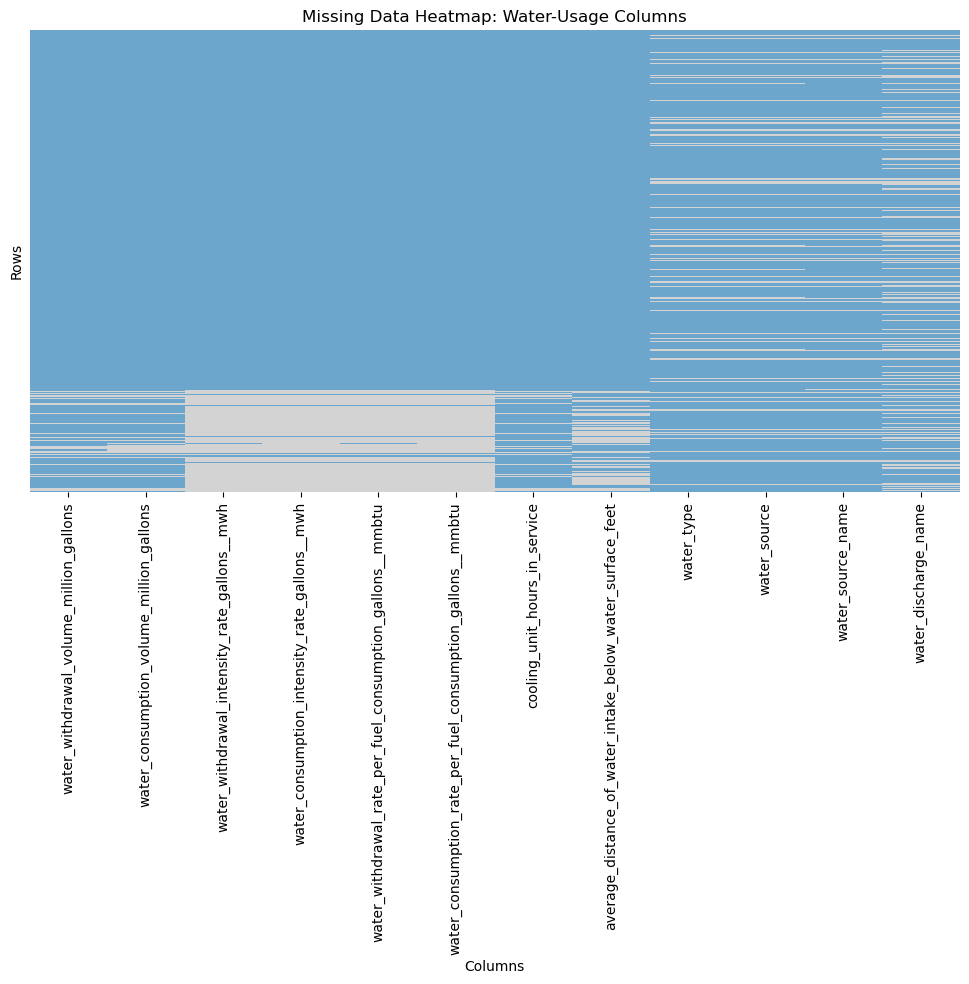

In [208]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from matplotlib.colors import ListedColormap

# List of columns to visualize
cols_2 = ['water_withdrawal_volume_million_gallons', 'water_consumption_volume_million_gallons', 'water_withdrawal_intensity_rate_gallons__mwh', 
                   'water_consumption_intensity_rate_gallons__mwh', 'water_withdrawal_rate_per_fuel_consumption_gallons__mmbtu', 
          'water_consumption_rate_per_fuel_consumption_gallons__mmbtu', 'cooling_unit_hours_in_service', 
          'average_distance_of_water_intake_below_water_surface_feet',
                   'water_type', 'water_source', 'water_source_name', 'water_discharge_name']

# Select only those columns
subset_df_2 = cooling_boiler_df[cols_2]  # or use .loc[:, cols]

# Create a boolean DataFrame: True for missing, False for present
missing_mask_2 = subset_df_2.isnull()

# Define custom colors: soft blue for present (False), light gray for missing (True)
colors = ["#6CA6CD", "#D3D3D3"]  # soft blue, light gray
cmap = ListedColormap(colors)

missing_water_heatmap = plt.figure(figsize=(12, 6))
sns.heatmap(
    missing_mask_2,
    cmap=cmap,
    cbar=False,
    yticklabels=False  # Hide row labels for clarity
)
plt.title("Missing Data Heatmap: Water-Usage Columns")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()



In [210]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/missing_water_heatmap.png'
missing_water_heatmap.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7/6.7_visualizations/missing_water_heatmap.png


### 🧊 Water Usage Column Notes

Among the water-related metrics, the most complete (based on a heatmap view of the dataset) are, in descending order of completeness:

* **`water_withdrawal_volume`** – Total volume of water drawn from a source (includes water that is later returned).
* **`water_consumption_volume`** – Water lost in the process (not returned to the source).
* **`cooling_unit_hours_in_service`** – Operational hours for the cooling unit.
* **`avg_distance_water_intake`** – Distance water travels from its source (relevant to ecological impact).

The **derived metrics**—those calculated per unit of output—are far more sparse:

* **`intensity_withdrawal_per_mwh`**
* **`intensity_consumption_per_mwh`**
* **`intensity_withdrawal_per_mmbtu`**
* **`intensity_consumption_per_mmbtu`**

These suffer from significant missingness, likely due to inconsistent availability of underlying data needed for calculation.

Additional attributes with **scattered missingness** include:

* **`water_type`**
* **`water_source`**
* **`water_source_name`**

---

### 📌 Next Steps: Investigating Missingness

To determine whether water metric gaps are **oversights** or **justified absences**, we’ll examine:

* **`generator_status`, `boiler_status`, `cooling_status`** – Is equipment active or retired?
* **`cooling_type_923`** – Operational characteristics from EIA-923.
* **`gen_tech_signature`** – Generator technology and fuel type.
* **`steam_plant_type`** – Indicates whether the plant meets EIA’s steam plant criteria.

⚠️ **Caveat:** The `steam_plant_type` classification is based on thresholds. Some non-steam plants may still include natural gas generators, so this field may not strictly map to expected configurations. Use caution when drawing conclusions.

---

### Re-naming columns for SQL

In [215]:
column_renames = {
    'water_withdrawal_volume_million_gallons': 'water_withdrawal_volume_mg',
    'water_consumption_volume_million_gallons': 'water_consumption_volume_mg',
    'water_withdrawal_intensity_rate_gallons__mwh': 'water_withdrawal_intensity_gal_mwh',
    'water_consumption_intensity_rate_gallons__mwh': 'water_consumption_intensity_gal_mwh',
    'water_withdrawal_rate_per_fuel_consumption_gallons__mmbtu': 'water_withdrawal_per_fuel_gal_mmbtu',
    'water_consumption_rate_per_fuel_consumption_gallons__mmbtu': 'water_consumption_per_fuel_gal_mmbtu',
    'average_distance_of_water_intake_below_water_surface_feet': 'avg_distance_water_intake_ft'
}

cooling_boiler_df.rename(columns=column_renames, inplace=True)


In [256]:
cooling_boiler_df[['water_type', 'water_source', 'water_source_name', 'water_discharge_name']].drop_duplicates()

,water_type,water_source,water_source_name,water_discharge_name
0,Fresh,Surface,Mobile River,Mobile River
12,NaN,NaN,Mobile River,NaN
84,Reclaimed,Discharge,Mobile River,Mobile River
228,Fresh,Surface,Coosa River,Coosa River
252,Fresh,Surface,Warrior River,Warrior River
...,...,...,...,...
706464,Fresh,Surface,Chickamauga Lake,Chickamauga Lake
714072,Fresh,Surface,Nova Chemical Co (Ohio River),Nova Chemical Co (Ohio River)
716580,Reclaimed,Discharge,Sabine River Authority Canal,cooling tower
748836,Reclaimed,Discharge,Mattawoman WWTF,NaN


## What the Columns Mean

- **water_type:**  
  Describes the general category of water used (e.g., Fresh, Reclaimed, Brackish).
- **water_source:**  
  The type or origin of the water supply (e.g., Surface, Groundwater, Discharge).
- **water_source_name:**  
  The specific name of the source from which water is withdrawn.
- **water_discharge_name:**  
  The specific name of the body of water where used water is discharged.

---

## An Example

| water_type | water_source | water_source_name | water_discharge_name |
|------------|--------------|-------------------|----------------------|
| Fresh      | Surface      | Mobile River      | Mobile River         |
| Reclaimed  | Discharge    | Mobile River      | Mobile River         |

---

## What’s Happening Here?

### 1. **Fresh / Surface / Mobile River**
-  The plant is withdrawing **fresh surface water** directly from the **Mobile River** and returning it to the same river.

### 2. **Reclaimed / Discharge / Mobile River**
- “Reclaimed” water with a source type “Discharge”: The plant is **using water that has already been used by someone else and discharged back into the Mobile River** (e.g., municipal wastewater, another industry’s effluent, or even its own prior discharge).
  - The “source” is the river, but specifically the **portion of the river that contains reclaimed water** (i.e., water that has been treated and returned to the river by upstream users).
  - After use, the plant discharges the water back into the same river.

---

## Significance

- **“Discharge” as a water source means the plant’s intake is from a water body that receives effluent (treated wastewater) from upstream sources.**
- This is important for tracking water reuse and for regulatory reasons:  
  - “Reclaimed” water use often counts toward **water conservation goals**.
  - It’s also relevant for **water quality** and permitting.

---

## How to Interpret

- **Both rows are using water from the Mobile River, but they differ in the regulatory/accounting status of the water:**
  - **Fresh/Surface:** Untreated, direct river withdrawal.
  - **Reclaimed/Discharge:** Treated wastewater (from another facility or municipal system) that has re-entered the river and is being withdrawn again.

---

In [262]:
# Replace NaNs with 'MISSING' in both columns before concatenation
cooling_boiler_df['water_signature'] = (
    cooling_boiler_df['water_type'].fillna('MISSING') + '_' +
    cooling_boiler_df['water_source'].fillna('MISSING')
)


In [270]:
cooling_boiler_df['water_signature'].value_counts(dropna=False)

water_signature
Fresh_Surface          393576
MISSING_MISSING        109452
Fresh_Ground            89400
Reclaimed_Discharge     54564
Other_Other             35856
Saline_Surface          28260
Brackish_Surface        25680
Fresh_Other              9756
Other_Ground             2184
Brackish_Ground          1452
Saline_Other              432
Saline_Ground             432
Other_MISSING             312
MISSING_Other             108
Reclaimed_Other            24
Reclaimed_Surface          12
Name: count, dtype: int64

# 📨 Final Steps

## Notes

Water Metrics and Fuel Metrics will be examined in SQL. This is important because the original dataframe is highly granular and includes attributes that do not apply to all technologies or cooling systems (e.g., fuel consumption by combined shaft turbines vs. steam turbines, or water metrics for dry cooling systems). Performing quick aggregations in SQL will allow us to efficiently summarize and filter the data as needed.

Additionally, rapid iteration of aggregations in SQL will help us uncover the slowly changing dimension (SCD) qualities of the dataset, since many attributes (such as technology configuration, fuel use, and water metrics) change over time between 2015 and 2023.

**Final steps before import:**
- Ensure all data types are compatible with SQL (e.g., integers, floats, strings, dates).
- Rearrange columns if necessary for clarity or schema requirements.
- Export the cleaned dataframe to CSV for import using the `COPY` command in pgAdmin.


In [276]:
column_renames = {
    'summer_capacity_of_steam_turbines_mw': 'summer_cap_steam_turbines_mw',
    'gross_generation_from_steam_turbines_mwh': 'gross_gen_steam_turbines_mwh',
    'net_generation_from_steam_turbines_mwh': 'net_gen_steam_turbines_mwh',
    'summer_capacity_associated_with_single_shaft_combined_cycle_units_mw': 'summer_cap_single_shaft_mw',
    'gross_generation_associated_with_single_shaft_combined_cycle_units_mwh': 'gross_gen_single_shaft_mwh',
    'net_generation_associated_with_single_shaft_combined_cycle_units_mwh': 'net_gen_single_shaft_mwh',
    'summer_capacity_associated_with_combined_cycle_gas_turbines_mw': 'summer_cap_combined_cycle_gt_mw',
    'gross_generation_associated_with_combined_cycle_gas_turbines_mwh': 'gross_gen_combined_cycle_gt_mwh',
    'net_generation_associated_with_combined_cycle_gas_turbines_mwh': 'net_gen_combined_cycle_gt_mwh',
    'fuel_consumption_from_all_fuel_types_mmbtu': 'fuel_consump_all_fuel_types_mmbtu',
    'fuel_consumption_from_steam_turbines_mmbtu': 'fuel_consump_steam_turbines_mmbtu',
    'fuel_consumption_from_single_shaft_combined_cycle_units_mmbtu': 'fuel_consump_single_shaft_mmbtu',
    'fuel_consumption_from_combined_cycle_gas_turbines_mmbtu': 'fuel_consump_combined_cycle_gt_mmbtu'
}


cooling_boiler_df.rename(columns=column_renames, inplace=True)



#### Remove 'number_operable_cooling_systems' (hidden extra spaces)

In [288]:
cooling_boiler_df.columns = cooling_boiler_df.columns.str.strip()
cooling_boiler_df.drop('number_operable_cooling_systems', axis=1, inplace=True)


#### Data Types remap

In [290]:
print(cooling_boiler_df.dtypes.to_string())

utility_id                                       int64
state                                           object
plant_code                                       int64
plant_name                                      object
year                                             int64
month                                            int64
generator_id                                    object
boiler_id                                       object
cooling_id                                      object
generator_primary_technology                    object
summer_cap_steam_turbines_mw                    object
gross_gen_steam_turbines_mwh                    object
net_gen_steam_turbines_mwh                      object
summer_cap_single_shaft_mw                      object
gross_gen_single_shaft_mwh                      object
net_gen_single_shaft_mwh                        object
summer_cap_combined_cycle_gt_mw                 object
gross_gen_combined_cycle_gt_mwh                 object
net_gen_co

In [297]:
numeric_columns = [
    'summer_cap_steam_turbines_mw',
    'gross_gen_steam_turbines_mwh',
    'net_gen_steam_turbines_mwh',
    'summer_cap_single_shaft_mw',
    'gross_gen_single_shaft_mwh',
    'net_gen_single_shaft_mwh',
    'summer_cap_combined_cycle_gt_mw',
    'gross_gen_combined_cycle_gt_mwh',
    'net_gen_combined_cycle_gt_mwh',
    'fuel_consump_all_fuel_types_mmbtu',
    'fuel_consump_steam_turbines_mmbtu',
    'fuel_consump_single_shaft_mmbtu',
    'fuel_consump_combined_cycle_gt_mmbtu',
    'coal_consumption_mmbtu',
    'natural_gas_consumption_mmbtu',
    'petroleum_consumption_mmbtu',
    'biomass_consumption_mmbtu',
    'other_gas_consumption_mmbtu',
    'other_fuel_consumption_mmbtu',
    'water_withdrawal_volume_mg',
    'water_consumption_volume_mg',
    'water_withdrawal_intensity_gal_mwh',
    'water_consumption_intensity_gal_mwh',
    'water_withdrawal_per_fuel_gal_mmbtu',
    'water_consumption_per_fuel_gal_mmbtu',
    'cooling_unit_hours_in_service',
    'avg_distance_water_intake_ft'
]

for col in numeric_columns:
    cooling_boiler_df[col] = pd.to_numeric(cooling_boiler_df[col], errors='coerce')


In [299]:
boolean_columns = [
    'combined_heat_and_power_generator',
    'generator_duct_burners',
    'cooling_type_mismatch',
    'unknown_cooling_with_water'
]

for col in boolean_columns:
    cooling_boiler_df[col] = cooling_boiler_df[col].astype('boolean')


In [301]:
print(cooling_boiler_df.dtypes.to_string())

utility_id                                       int64
state                                           object
plant_code                                       int64
plant_name                                      object
year                                             int64
month                                            int64
generator_id                                    object
boiler_id                                       object
cooling_id                                      object
generator_primary_technology                    object
summer_cap_steam_turbines_mw                   float64
gross_gen_steam_turbines_mwh                   float64
net_gen_steam_turbines_mwh                     float64
summer_cap_single_shaft_mw                     float64
gross_gen_single_shaft_mwh                     float64
net_gen_single_shaft_mwh                       float64
summer_cap_combined_cycle_gt_mw                float64
gross_gen_combined_cycle_gt_mwh                float64
net_gen_co

In [303]:
int_columns = [
    'generator_inservice_month', 'generator_inservice_year',
    'generator_retirement_month', 'generator_retirement_year',
    'boiler_inservice_month', 'boiler_inservice_year',
    'boiler_retirement_month', 'boiler_retirement_year',
    'cooling_inservice_month', 'cooling_inservice_year'
]

for col in int_columns:
    cooling_boiler_df[col] = pd.to_numeric(cooling_boiler_df[col], errors='coerce').astype('Int64')


In [305]:
print(cooling_boiler_df.dtypes.to_string())

utility_id                                       int64
state                                           object
plant_code                                       int64
plant_name                                      object
year                                             int64
month                                            int64
generator_id                                    object
boiler_id                                       object
cooling_id                                      object
generator_primary_technology                    object
summer_cap_steam_turbines_mw                   float64
gross_gen_steam_turbines_mwh                   float64
net_gen_steam_turbines_mwh                     float64
summer_cap_single_shaft_mw                     float64
gross_gen_single_shaft_mwh                     float64
net_gen_single_shaft_mwh                       float64
summer_cap_combined_cycle_gt_mw                float64
gross_gen_combined_cycle_gt_mwh                float64
net_gen_co

In [307]:
cooling_boiler_df.shape

(751500, 79)

In [309]:
# Export data to csv
path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7'
output_file = 'cooling_boiler_df_FINAL.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
cooling_boiler_df.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'cooling_boiler_df_FINAL.csv' has been created successfully.


# Towards defining training dataset: plants still in operation by 2023 (using geojson 2024)

In [324]:
!pip install geopandas

python(72869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [326]:
pip install --upgrade pip

python(72883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1
    Uninstalling pip-25.1:
      Successfully uninstalled pip-25.1
Note: you may need to restart the kernel to use updated packages.


In [329]:
import geopandas as gpd

# Load the GeoJSON file
geo_df = gpd.read_file('/Users/amyzhang/Desktop/A6_Dashboard/6.3/Power_Plants.geojson')

# Quick peek
geo_df.head()


,OBJECTID,Plant_Code,Plant_Name,Utility_ID,Utility_Name,sector_name,Street_Address,City,County,State,...,Nuclear_MW,Crude_MW,Solar_MW,Wind_MW,Other_MW,Source,Period,Longitude,Latitude,geometry
0,35853,1,Sand Point,63560,"Sand Point Generating, LLC",Electric Utility,100 Power Plant Way,Sand Point,Aleutians East,Alaska,...,NaN,1.3,NaN,0.4,NaN,"EIA-860, EIA-860M and EIA-923",202406,-160.497222,55.339722,POINT (-160.49722 55.33972)
1,35854,2,Bankhead Dam,195,Alabama Power Co,Electric Utility,19001 Lock 17 Road,Northport,Tuscaloosa,Alabama,...,NaN,NaN,NaN,NaN,NaN,"EIA-860, EIA-860M and EIA-923",202406,-87.356823,33.458665,POINT (-87.35682 33.45867)
2,35855,3,Barry,195,Alabama Power Co,Electric Utility,North Highway 43,Bucks,Mobile,Alabama,...,NaN,NaN,NaN,NaN,NaN,"EIA-860, EIA-860M and EIA-923",202406,-88.010300,31.006900,POINT (-88.0103 31.0069)
3,35856,4,Walter Bouldin Dam,195,Alabama Power Co,Electric Utility,750 Bouldin Dam Road,Wetumpka,Elmore,Alabama,...,NaN,NaN,NaN,NaN,NaN,"EIA-860, EIA-860M and EIA-923",202406,-86.283056,32.583889,POINT (-86.28306 32.58389)
4,35857,9,Copper,5701,El Paso Electric Co,Electric Utility,651 Hawkins Blvd.,El Paso,El Paso,Texas,...,NaN,NaN,NaN,NaN,NaN,"EIA-860, EIA-860M and EIA-923",202406,-106.375000,31.756900,POINT (-106.375 31.7569)


In [332]:
# First, standardize column names
geo_df = geo_df.rename(columns={'Plant_Code': 'plant_code'})

# Merge on 'plant_code'
cooling_boiler_geo = cooling_boiler_df.merge(geo_df[['plant_code', 'Plant_Name', 'State', 'Latitude', 'Longitude', 'geometry']],
                                     on='plant_code',
                                     how='left')

# Sanity check
print(cooling_boiler_geo.shape)
cooling_boiler_geo[['plant_code', 'Plant_Name', 'Latitude', 'Longitude']].head()


(751500, 84)


,plant_code,Plant_Name,Latitude,Longitude
0,3,Barry,31.0069,-88.0103
1,3,Barry,31.0069,-88.0103
2,3,Barry,31.0069,-88.0103
3,3,Barry,31.0069,-88.0103
4,3,Barry,31.0069,-88.0103


In [335]:
missing_plants = cooling_boiler_geo[cooling_boiler_geo['Latitude'].isna()]['plant_code'].nunique()
total_plants = cooling_boiler_geo['plant_code'].nunique()

print(f"Unique plants missing coordinates: {missing_plants} out of {total_plants}")

Unique plants missing coordinates: 211 out of 1009


## 211 out of 1009 plants are no longer included in 2024 EIA geographic data. 
- These 211 plant_codes represent how many rows without latitude/longitude data? **73,668 rows; ~10% of data**
- Of these, how many were still operating in 2023 (with a 'configuration_type' that was **not** 'Unoperable)? **15** 

In [348]:
# STEP 1: Get plant codes that are missing coordinates
plants_missing_coords = cooling_boiler_geo[cooling_boiler_geo['Latitude'].isna()]['plant_code'].unique()

# STEP 2: Filter full cooling_boiler_geo dataset to only those plants
plants_missing_df = cooling_boiler_geo[cooling_boiler_geo['plant_code'].isin(plants_missing_coords)]

print(plants_missing_df.head())
print(plants_missing_df.shape)

     utility_id state  plant_code plant_name  year  month generator_id  \
228         195    AL           7    Gadsden  2023      1            1   
229         195    AL           7    Gadsden  2023      2            1   
230         195    AL           7    Gadsden  2023      3            1   
231         195    AL           7    Gadsden  2023      4            1   
232         195    AL           7    Gadsden  2023      5            1   

    boiler_id cooling_id generator_primary_technology  ...  \
228         1        1-2    Natural Gas Steam Turbine  ...   
229         1        1-2    Natural Gas Steam Turbine  ...   
230         1        1-2    Natural Gas Steam Turbine  ...   
231         1        1-2    Natural Gas Steam Turbine  ...   
232         1        1-2    Natural Gas Steam Turbine  ...   

     generator_status_full  boiler_status_full  cooling_status_full  \
228                Retired             Retired   Operating / Active   
229                Retired             R

In [352]:
cooling_boiler_geo.shape

(751500, 84)

In [356]:
plants_missing_df[['year', 'utility_id', 'state', 'plant_code', 
                   'configuration_type', 
                   'cooling_system_signature', 
                   'gen_tech_signature', 
                   'generator_status_full', 'boiler_status_full', 
                   'cooling_status_full', 'cooling_design_signature']].drop_duplicates().head(50)

,year,utility_id,state,plant_code,configuration_type,cooling_system_signature,gen_tech_signature,generator_status_full,boiler_status_full,cooling_status_full,cooling_design_signature
228,2023,195,AL,7,Unoperable,7_1_1_1-2,(NG) Natural Gas_(ST) Steam Turbine,Retired,Retired,Operating / Active,(ON) Once through No Cool Pond | MISSING
240,2023,195,AL,7,Unoperable,7_2_2_1-2,(NG) Natural Gas_(ST) Steam Turbine,Retired,Retired,Operating / Active,(ON) Once through No Cool Pond | MISSING
252,2023,195,AL,8,Unoperable,8_10_10_10,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
264,2023,195,AL,8,Unoperable,8_6_6_5-7,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
276,2023,195,AL,8,Unoperable,8_7_7_5-7,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
288,2023,195,AL,8,Unoperable,8_8_8_8-9,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
300,2023,195,AL,8,Unoperable,8_9_9_8-9,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
540,2023,18642,AL,50,Unoperable,50_1_1_1,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
552,2023,18642,AL,50,Unoperable,50_2_2_1,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
564,2023,18642,AL,50,Unoperable,50_3_3_1,(BIT) Bituminous Coal_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING


In [360]:
# STEP 3: Group by plant and config type to see which of these had operable units in 2023
operable_configs_missing_geo = plants_missing_df[
    (plants_missing_df['year'] == 2023) &
    (plants_missing_df['configuration_type'] != 'Unoperable')
]

In [362]:
operable_configs_missing_geo[['year', 'utility_id', 'state', 'plant_code', 
                   'configuration_type', 
                   'cooling_system_signature', 
                   'gen_tech_signature', 
                   'generator_status_full', 'boiler_status_full', 
                   'cooling_status_full', 'cooling_design_signature']].drop_duplicates().head(50)

,year,utility_id,state,plant_code,configuration_type,cooling_system_signature,gen_tech_signature,generator_status_full,boiler_status_full,cooling_status_full,cooling_design_signature
2064,2023,22484,CA,356,Simple,356_5_5_5,(NG) Natural Gas_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
2076,2023,22484,CA,356,Simple,356_6_6_6,(NG) Natural Gas_(ST) Steam Turbine,Retired,Retired,Retired,(ON) Once through No Cool Pond | MISSING
2088,2023,22484,CA,356,Simple,356_8_8_8,(NG) Natural Gas_(ST) Steam Turbine,Retired,Retired,Operating / Active,(ON) Once through No Cool Pond | MISSING
2664,2023,12384,IL,384,Complex,384_7_71_7,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Operating / Active,(ON) Once through No Cool Pond | (HT) Hybrid T...
2673,2023,12384,IL,384,Complex,384_7_72_7,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Operating / Active,(ON) Once through No Cool Pond | (HT) Hybrid T...
2682,2023,12384,IL,384,Complex,384_8_81_8,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Operating / Active,(ON) Once through No Cool Pond | (HT) Hybrid T...
2691,2023,12384,IL,384,Complex,384_8_82_8,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Operating / Active,(ON) Once through No Cool Pond | (HT) Hybrid T...
2700,2023,12384,IL,384,Complex,384_7_71_PLANT,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Missing,MISSING | MISSING
2709,2023,12384,IL,384,Complex,384_7_72_PLANT,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Missing,MISSING | MISSING
2718,2023,12384,IL,384,Complex,384_8_81_PLANT,(NG) Natural Gas_(ST) Steam Turbine,Retired,Operating / Active,Missing,MISSING | MISSING


In [364]:
# STEP 4: How many such plants exist?
operable_missing_count = operable_configs_missing_geo['plant_code'].nunique()
print(f"Plants missing geo info but still operable in 2023: {operable_missing_count}")

Plants missing geo info but still operable in 2023: 15


In [368]:
cooling_boiler_geo['plant_code'].nunique()

1009

In [372]:
geo_df['plant_code'].nunique()

12798

In [374]:
shared_plant_codes = set(cooling_boiler_geo['plant_code']).intersection(set(geo_df['plant_code']))
count_shared = len(shared_plant_codes)
print(count_shared)


798


## Modeling Strategy: Two Approaches to Water Use Prediction

As we prepare our training dataset to model water usage by electricity-generating plants in the U.S., two main approaches emerge:

1. **Current Regime Prediction**  
   This approach filters the dataset to include only plants still in operation by 2024. The goal is to model water usage reflective of the present moment—shaped by technological shifts, plant retirements, and policy changes up to now. It offers a real-world baseline against which predictions can later be verified, once 2024 data is released (expected by November 2025).

2. **Historical Pattern Modeling**  
   This broader approach includes all available plant data, even from those retired before 2024. While less precise in reflecting current infrastructure, it enables us to explore more general patterns of water use across configurations and eras—creating a kind of abstract taxonomy of cooling system designs and generator technologies. This view is useful for scenario modeling or parametric design strategies that consider a diverse and locally responsive energy future.

We opt to preserve both pathways in the project:
- The *current regime* subset gives us a real-world benchmark for predictive accuracy.
- The *historical pattern* dataset allows for conceptual exploration and understanding of legacy system impacts.

Maintaining both datasets keeps the door open for multiple interpretive and applied use cases, especially as we approach energy transition modeling with an eye toward infrastructure diversity and decentralization.


In [377]:
cooling_boiler_geo.dropna(subset=['Latitude'], inplace=True)


In [379]:
cooling_boiler_geo.shape

(677832, 84)

In [381]:
# Export data to csv
path = '/Users/amyzhang/Desktop/A6_Dashboard/AZ_sisyphus/CF6.7'
output_file = 'cooling_boiler_geo_2024.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
cooling_boiler_geo.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'cooling_boiler_geo_2024.csv' has been created successfully.
